# **EXPLORING JOB DISSATISFACTION IN THE UK USING REDDIT DATA (2025 Dataset)**

## **AN NLP-BASED THEMATIC AND SENTIMENT ANALYSIS**


### **Student Name**: Awopetu Rasheed Oluwadamilare

### **Student Number**: 202432121

### **Library Installation**

In [3]:
pip install praw pandas tqdm python-dotenv emoji vaderSentiment textblob wordcloud pyLDAvis gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 79.4 MB/s eta 0:00:00


### **Import the necessary libraries**

In [4]:
import pandas as pd
import os, time, json
import praw
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import re, emoji, nltk, spacy
import torch
import pyLDAvis
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


from dotenv import load_dotenv
from datetime import datetime, timedelta
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from nltk.corpus import stopwords
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import LinearSVC
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

### **Loading Environment Variable from .env File**

##### To keep Reddit API credentials secure, we store them in a `.env` file instead of hardcoding into the script. So anytime we need them we can easily pass them to the reddit API easily

In [ ]:
environment_variable = load_dotenv()
if environment_variable:
    print("Environment variables loaded successfully.")
else:
    print("Failed to load environment variables. Please Upload .env file")

Environment variables loaded successfully.


### **Loading Dataset & Data Collection**

We will collects Reddit posts and comments related to **job dissatisfaction & Satisfaction in the UK**.  
- Subreddits: `ukjobs`, `AskUK`, `CasualUK`, `unitedkingdom`, `britishproblems`, `antiwork`, `antiwork`, `WorkReform`, `careerguidance`, `AskHR`, `britishproblems`,.  
- Queries: dissatisfaction terms (e.g., *"hate my job"*, *"toxic workplace"*) and satisfaction terms (e.g., *"love my job"*).  
- UK filter ensures posts are from UK-focused subs or mention UK places.  
- Data Period Lenght: last **9 months and 25 days** of activity. **January 2025 to October 25**  
- Output: two CSV files (`reddit_posts_uk_jobs.csv`, `reddit_comments_uk_jobs.csv`).

##### Firstly, let create a subreddit list that we intend to use.

In [ ]:
SUBREDDITS = [
    "UKJobs", "AskUK", "CasualUK", "unitedkingdom", "antiwork", "WorkReform",
    "careerguidance", "AskHR", "britishproblems", "recruitinghell", "WorkReformUK"
]

print(f"List of subreddits: {(SUBREDDITS)}")

List of subreddits: ['UKJobs', 'AskUK', 'CasualUK', 'unitedkingdom', 'antiwork', 'WorkReform', 'careerguidance', 'AskHR', 'britishproblems', 'recruitinghell', 'WorkReformUK']


##### **Query Terms**

Two sets of keyword queries were defined to guide Reddit searches:  

- **Job Dissatisfaction** → phrases like *"hate my job"*, *"toxic workplace"*, *"low pay"*, *"burnout"*, *"bad boss"*, and *"bullying at work"*.  
- **Job Satisfaction** → phrases like *"love my job"*, *"happy at work"*, *"good boss"*, *"work life balance"*, and *"fair pay"*.  

These terms ensure we capture a broad range of posts expressing both negative and positive experiences with work in the UK.

In [ ]:
DISSATISFACTION_TERMS = [
    "job dissatisfaction", "hate my job", "toxic workplace", "burnout", "overworked",
    "bad boss", "micromanagement", "low pay", "underpaid", "quit my job", "resign",
    "stress at work", "bullying at work", "zero hours", "unhappy at work", "stressful job", "poor management", "burnt out", "miserable at work",
    "dead-end job", "exploited at work", "no work-life balance", "hate going to work", "rejection", "really bad", "unreasonable", "management cuts benefits"
]

print(f"List of Dissatisfaction terms: {(DISSATISFACTION_TERMS)}")

List of Dissatisfaction terms: ['job dissatisfaction', 'hate my job', 'toxic workplace', 'burnout', 'overworked', 'bad boss', 'micromanagement', 'low pay', 'underpaid', 'quit my job', 'resign', 'stress at work', 'bullying at work', 'zero hours', 'unhappy at work', 'stressful job', 'poor management', 'burnt out', 'miserable at work', 'dead-end job', 'exploited at work', 'no work-life balance', 'hate going to work', 'rejection', 'really bad', 'unreasonable', 'management cuts benefits']


In [ ]:
SATISFACTION_TERMS = [
    "love my job", "happy at work", "good boss", "great team", "work life balance",
    "supportive manager", "flexible working", "fair pay"
]
print(f"List of Satisfaction terms: {(SATISFACTION_TERMS)}")

List of Satisfaction terms: ['love my job', 'happy at work', 'good boss', 'great team', 'work life balance', 'supportive manager', 'flexible working', 'fair pay']


##### A regex filter **(`UK_REGEX`)** was applied to retain only posts from UK-focused subreddits or those mentioning UK locations (e.g., London, Manchester, Scotland).

In [ ]:
UK_REGEX = re.compile(r"\b(UK|United Kingdom|England|Scotland|Wales|Northern Ireland|London|Manchester|Birmingham|Leeds|Glasgow|Bristol|Liverpool)\b", re.IGNORECASE)

##### Posts were collected from the **last 180 days (Approximately 6 months)** to capture recent discussions on job dissatisfaction and satisfaction in the UK.

In [ ]:
DAYS_BACK = 297

##### **Reddit API Authentication** -> Access to Reddit data was established using the **PRAW (Python Reddit API Wrapper)** library.  Authentication requires three environment variables loaded from the `.env` file:

In [ ]:
reddit = praw.Reddit(client_id=os.getenv("CLIENT_ID"), client_secret=os.getenv("CLIENT_SECRET"), user_agent=os.getenv("USER_AGENT"), check_for_async=False, )

##### A helper function was used to retain only posts from UK-focused subreddits or those mentioning UK locations.  

In [ ]:
def is_uk_related(text: str, subreddit: str) -> bool:
    if subreddit.lower() in {"ukjobs", "askuk", "casualuk", "unitedkingdom", "britishproblems"}:
        return True
    return bool(UK_REGEX.search(text or ""))

##### A custom function was used to search target subreddits with defined queries, filter by UK relevance and time window, and return labelled posts with top-level comments for analysis.  

#### **Push shift documentation** -> https://github.com/pushshift/api

In [ ]:
def search_and_collect(queries, label):
    """
    Search posts for each query across target subreddits, INCLUDE metadata AND top comments.
    label = 'dissatisfaction' or 'satisfaction'
    """
    since = int((datetime.utcnow() - timedelta(days=DAYS_BACK)).timestamp())
    rows_posts, rows_comments = [], []

    for sr in SUBREDDITS:
        sub = reddit.subreddit(sr)
        for q in queries:
            results = sub.search(q, sort="new", limit=500)
            for s in tqdm(results, desc=f"{sr} | {q}"):
                if s.created_utc < since:
                    continue

                # UK filter
                blob = f"{s.title}\n{s.selftext or ''}"
                if not is_uk_related(blob, sr):
                    continue

                post_row = {
                    "id": s.id,
                    "subreddit": sr,
                    "created_utc": s.created_utc,
                    "created_iso": datetime.utcfromtimestamp(s.created_utc).isoformat(),
                    "author": str(s.author) if s.author else None,
                    "title": s.title,
                    "selftext": s.selftext,
                    "score": s.score,
                    "num_comments": s.num_comments,
                    "url": s.url,
                    "permalink": f"https://www.reddit.com{s.permalink}",
                    "query": q,
                    "label": label,
                    "source": "reddit_api",
                }
                rows_posts.append(post_row)

                s.comment_sort = "top"
                s.comments.replace_more(limit=0)
                for c in s.comments[:25]:
                    rows_comments.append({
                        "post_id": s.id,
                        "comment_id": c.id,
                        "created_utc": c.created_utc,
                        "created_iso": datetime.utcfromtimestamp(c.created_utc).isoformat(),
                        "author": str(c.author) if c.author else None,
                        "body": c.body,
                        "score": c.score,
                        "permalink": f"https://www.reddit.com{c.permalink}",
                        "subreddit": sr,
                        "post_query": q,
                        "post_label": label,
                    })

                time.sleep(0.6)
    return pd.DataFrame(rows_posts), pd.DataFrame(rows_comments)

###### **Data Collection and Storage**
The script collects Reddit posts for both dissatisfaction and satisfaction queries, merges and de-duplicates results, and saves labelled posts and comments as CSV files for subsequent NLP, sentiment, and thematic analysis.  

In [ ]:
if __name__ == "__main__":
    posts_diss, comments_diss = search_and_collect(DISSATISFACTION_TERMS, "dissatisfaction")
    posts_sat,  comments_sat  = search_and_collect(SATISFACTION_TERMS, "satisfaction")

    posts = pd.concat([posts_diss, posts_sat], ignore_index=True)
    posts = posts.drop_duplicates(subset=["id"])
    comments = pd.concat([comments_diss, comments_sat], ignore_index=True)
    comments = comments.drop_duplicates(subset=["comment_id"])

    os.makedirs("data", exist_ok=True)
    posts.to_csv("data/reddit_posts_uk_jobs.csv", index=False)
    comments.to_csv("data/reddit_comments_uk_jobs.csv", index=False)

    print("Saved data/reddit_posts_uk_jobs.csv and data/reddit_comments_uk_jobs.csv")

/tmp/ipython-input-2463737130.py:6: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  since = int((datetime.utcnow() - timedelta(days=DAYS_BACK)).timestamp())
UKJobs | job dissatisfaction: 0it [00:00, ?it/s]/tmp/ipython-input-2463737130.py:26: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "created_iso": datetime.utcfromtimestamp(s.created_utc).isoformat(),
/tmp/ipython-input-2463737130.py:47: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "created_iso": datetime

Saved data/reddit_posts_uk_jobs.csv and data/reddit_comments_uk_jobs.csv


###### We are using pandas to load two CSV files. One with Reddit posts and another with comments from the UK jobs subreddit. We let pandas handle any tricky line breaks and skip over bad lines so nothing breaks while loading. In the end, we just print out the number of rows and columns to get a quick feel for how big our datasets are.

In [ ]:
posts = pd.read_csv("data/reddit_posts_uk_jobs.csv", lineterminator='\n')
comments = pd.read_csv("data/reddit_comments_uk_jobs.csv", lineterminator='\n', on_bad_lines='skip')

print("Posts:", posts.shape)
print("Comments:", comments.shape)

Posts: (5232, 14)
Comments: (58436, 11)


### **CSV File combined**

###### Let **combined the 2 datset** together so we can be able to work with a single dataset

###### We’re adding a new column called source to both our datasets. We let the posts have the label "post" and the comments have the label "comment". This way, when we eventually combine or analyze everything together, we’ll know exactly which entries came from posts and which came from comments.

In [ ]:
posts["source"] = "post"
comments["source"] = "comment"

###### For the posts, we fill in any missing titles or selftexts with empty strings, then combine them into one column called text_raw so each post has a single block of text. For the comments, we fill any missing body text with an empty string and store it in text_raw as well.

In [ ]:
posts["title"] = posts["title"].fillna("")
posts["selftext"] = posts["selftext"].fillna("")
posts["text_raw"] = (posts["title"] + " " + posts["selftext"]).str.strip()

comments["body"] = comments["body"].fillna("")
comments["text_raw"] = comments["body"]

###### Streamlining our data by keeping only the most important columns. For the posts, we select useful fields like the post ID, subreddit, author, text, score, and a few others that we’ll need for analysis. For the comments, we first rename some columns like changing comment_id to id, post_query to query, and post_label to label so they match the posts dataset. Then, we keep the same set of columns as in the posts DataFrame. This makes both datasets consistent and ready to be combined or compared later on.

In [ ]:
# Columns to keep for posts
posts_small = posts[[
    "id","subreddit","created_utc","author","text_raw","score",
    "query","label","source","permalink"
]]

# Columns to keep for comments
comments_small = comments.rename(columns={
    "comment_id": "id",
    "post_query": "query",
    "post_label": "label"
})[[
    "id","subreddit","created_utc","author","text_raw","score",
    "query","label","source","permalink"
]]

###### We use pd.concat() to stack them together and set ignore_index=True so the index resets automatically. After merging, we print out the new dataset’s shape to see how big it is, and then display the first few rows with dataset.head() to make sure everything looks right.

In [ ]:
dataset = pd.concat([posts_small, comments_small], ignore_index=True)
print("Combined dataset shape:", dataset.shape)
dataset.head()

Combined dataset shape: (63668, 10)


,id,subreddit,created_utc,author,text_raw,score,query,label,source,permalink
0,1ltd0pl,UKJobs,1.751838e+09,ZealousidealFig5,Is there a correlation between unemployment an...,2,job dissatisfaction,dissatisfaction,post,https://www.reddit.com/r/UKJobs/comments/1ltd0...
1,1l28f88,UKJobs,1.748947e+09,ZebraShark,Me and a colleague have been shortlisted for s...,9,job dissatisfaction,dissatisfaction,post,https://www.reddit.com/r/UKJobs/comments/1l28f...
2,1k1kp8i,UKJobs,1.744916e+09,VegetaGuy,Looking for advice Going to try condense this ...,2,job dissatisfaction,dissatisfaction,post,https://www.reddit.com/r/UKJobs/comments/1k1kp...
3,1of5hu1,UKJobs,1.761331e+09,daddysnorlaxxx,Is the point of life to just work till your to...,10,hate my job,dissatisfaction,post,https://www.reddit.com/r/UKJobs/comments/1of5h...
4,1oesu9x,UKJobs,1.761297e+09,Sambo181,Handing in notice when staff are off? Hello ev...,9,hate my job,dissatisfaction,post,https://www.reddit.com/r/UKJobs/comments/1oesu...


##### Saving the combined dataset so we can use it in our sentiment analysis

In [ ]:
dataset.to_csv('2025_JOB_Dissatisfaction.csv', index=False)

#### **Loading Saved Dataset**

###### We’re importing our dataset from a CSV file and taking a quick look at the top few records to get familiar with the structure of the data before we dive into analysis.

In [ ]:
Dataset = pd.read_csv('2025_JOB_Dissatisfaction.csv')
Dataset.head()

,id,subreddit,created_utc,author,text_raw,score,query,label,source,permalink
0,1ltd0pl,UKJobs,1.751838e+09,ZealousidealFig5,Is there a correlation between unemployment an...,2,job dissatisfaction,dissatisfaction,post,https://www.reddit.com/r/UKJobs/comments/1ltd0...
1,1l28f88,UKJobs,1.748947e+09,ZebraShark,Me and a colleague have been shortlisted for s...,9,job dissatisfaction,dissatisfaction,post,https://www.reddit.com/r/UKJobs/comments/1l28f...
2,1k1kp8i,UKJobs,1.744916e+09,VegetaGuy,Looking for advice Going to try condense this ...,2,job dissatisfaction,dissatisfaction,post,https://www.reddit.com/r/UKJobs/comments/1k1kp...
3,1of5hu1,UKJobs,1.761331e+09,daddysnorlaxxx,Is the point of life to just work till your to...,10,hate my job,dissatisfaction,post,https://www.reddit.com/r/UKJobs/comments/1of5h...
4,1oesu9x,UKJobs,1.761297e+09,Sambo181,Handing in notice when staff are off? Hello ev...,9,hate my job,dissatisfaction,post,https://www.reddit.com/r/UKJobs/comments/1oesu...


### **Data Exploration**

###### Let's examining and understanding our dataset before doing any analysis or modeling.

##### **Displaying basic info of the Dataset**

In [ ]:
print(Dataset.shape)

(63668, 10)


In [ ]:
print(Dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63668 entries, 0 to 63667
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           63668 non-null  object 
 1   subreddit    63668 non-null  object 
 2   created_utc  63668 non-null  float64
 3   author       59653 non-null  object 
 4   text_raw     63667 non-null  object 
 5   score        63668 non-null  int64  
 6   query        63668 non-null  object 
 7   label        63668 non-null  object 
 8   source       63668 non-null  object 
 9   permalink    63668 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 4.9+ MB
None


##### **Checking Missing Value**

In [ ]:
print(Dataset.isnull().sum())

id                0
subreddit         0
created_utc       0
author         4015
text_raw          1
score             0
query             0
label             0
source            0
permalink         0
dtype: int64


###### From the dataset we discover we only have NAN only in the author role and also we have 1 NAN is text_raw. all this will be cleaned during the Data Cleaning Process

##### **Checking for Duplicates**

In [ ]:
print(Dataset.duplicated(subset=['text_raw']).sum())

5656


###### We discovered that we have 5,656 Duplicates in our Dataset. We are going to remove all this duplicates during the data cleaning

###### Let check our `label` field that we go from the **Reddit API**  

In [ ]:
print(Dataset['label'].value_counts())

label
dissatisfaction    48577
satisfaction       15091
Name: count, dtype: int64


###### We clearly discovered that we have 48,577 data that is related to dissatisfaction and 15,091 data that relate to satisfaction.

/tmp/ipython-input-7856422.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=Dataset, palette=["red", "green"])


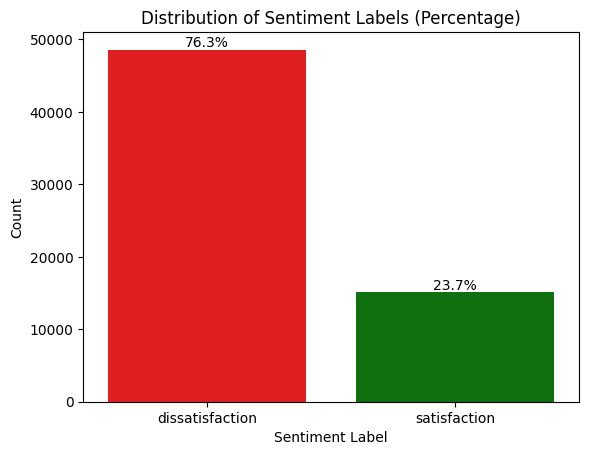

In [ ]:
ax = sns.countplot(x='label', data=Dataset, palette=["red", "green"])

total = len(Dataset)

for p in ax.patches:
    percentage = 100 * p.get_height() / total
    ax.annotate(f'{percentage:.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.title('Distribution of Sentiment Labels (Percentage)')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

##### Let explore data based on Subreddit

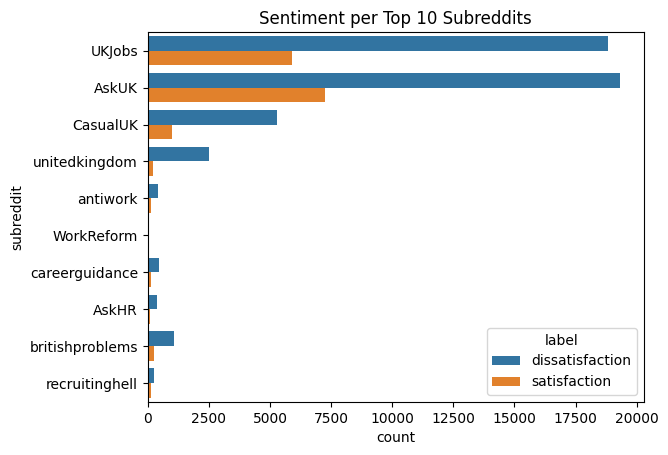

In [ ]:
top_subs = Dataset['subreddit'].value_counts().head(11).index
sns.countplot(y='subreddit', hue='label', data=Dataset[Dataset['subreddit'].isin(top_subs)])
plt.title('Sentiment per Top 10 Subreddits')
plt.show()

###### Let’s find the top subreddits, filter our dataset to include only them, and see how their sentiments compare

In [ ]:
top_subs = Dataset['subreddit'].value_counts().head(11).index
top_data = Dataset[Dataset['subreddit'].isin(top_subs)]
sentiment_table = pd.crosstab(top_data['subreddit'], top_data['label'])
display(sentiment_table)

label,dissatisfaction,satisfaction
subreddit,,
AskHR,397,87
AskUK,19327,7256
CasualUK,5270,994
UKJobs,18847,5920
WorkReform,49,0
antiwork,410,117
britishproblems,1076,256
careerguidance,449,115
recruitinghell,246,133


###### Let’s find the top subreddits, filter our dataset to include only them, and see how their sentiments compare using the percentage

In [ ]:
top_subs = Dataset['subreddit'].value_counts().head(10).index
top_data = Dataset[Dataset['subreddit'].isin(top_subs)]
sentiment_percent = pd.crosstab(top_data['subreddit'], top_data['label'], normalize='index') * 100
sentiment_percent = sentiment_percent.round(1)
display(sentiment_percent)

label,dissatisfaction,satisfaction
subreddit,,
AskHR,82.0,18.0
AskUK,72.7,27.3
CasualUK,84.1,15.9
UKJobs,76.1,23.9
WorkReform,100.0,0.0
antiwork,77.8,22.2
britishproblems,80.8,19.2
careerguidance,79.6,20.4
recruitinghell,64.9,35.1


###### Let’s create word clouds to visualize what people talk about most comparing positive (satisfaction) and negative (dissatisfaction) words side by side

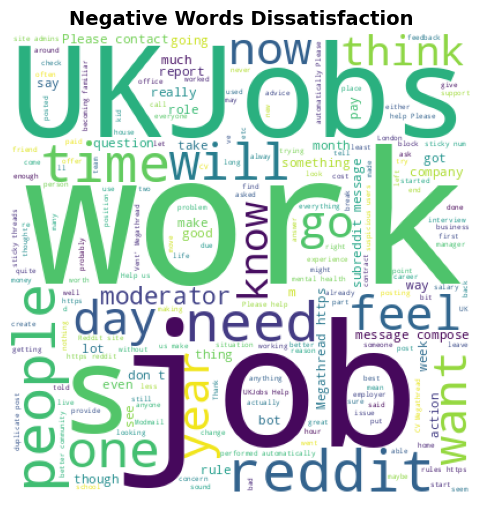

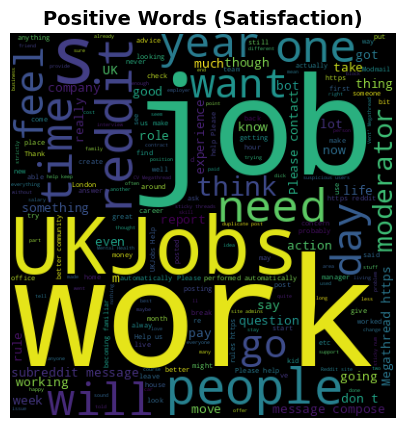

In [ ]:
pos_text = ' '.join(Dataset[Dataset['label']=='satisfaction']['text_raw'])
neg_text = ' '.join(Dataset.loc[Dataset['label'] == 'dissatisfaction', 'text_raw'].dropna().astype(str))

plt.figure(figsize=(6, 6))
plt.imshow(WordCloud(width=400, height=400, background_color='white').generate(neg_text))
plt.title('Negative Words Dissatisfaction', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=400, height=400).generate(pos_text))
plt.title('Positive Words (Satisfaction)', fontsize=14, fontweight='bold')
plt.axis('off')

plt.show()

###### **Frequency of each unique based on Query**

Unique queries: ['job dissatisfaction' 'hate my job' 'toxic workplace' 'burnout'
 'overworked' 'bad boss' 'micromanagement' 'low pay' 'underpaid'
 'quit my job' 'resign' 'stress at work' 'bullying at work' 'zero hours'
 'unhappy at work' 'stressful job' 'poor management' 'burnt out'
 'miserable at work' 'dead-end job' 'exploited at work'
 'no work-life balance' 'hate going to work' 'rejection' 'really bad'
 'unreasonable' 'management cuts benefits' 'love my job' 'happy at work'
 'good boss' 'great team' 'work life balance' 'supportive manager'
 'flexible working' 'fair pay']


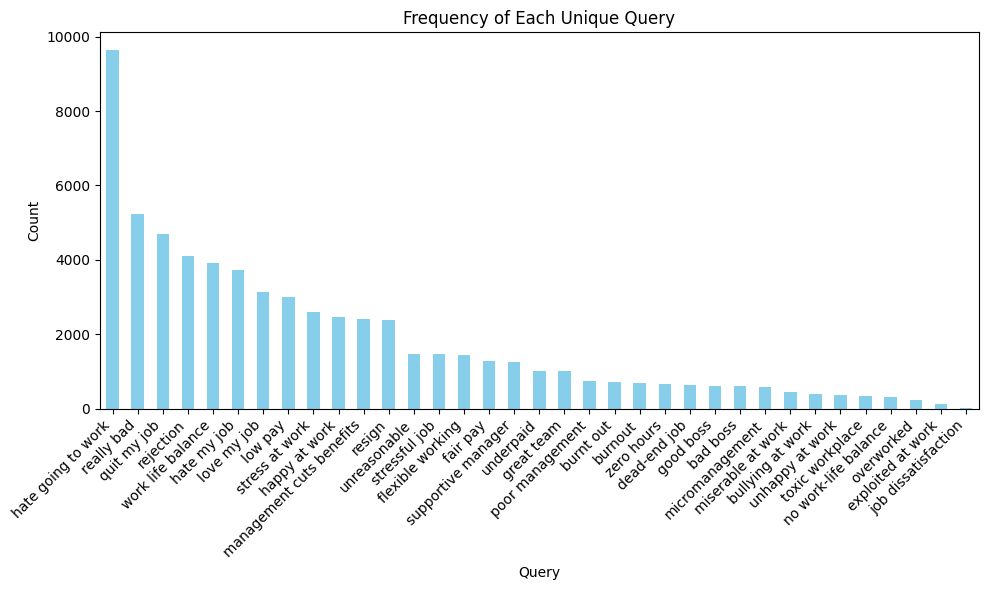

In [ ]:
query_counts = Dataset['query'].value_counts()

print("Unique queries:", Dataset['query'].unique())

plt.figure(figsize=(10, 6))
query_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Each Unique Query')
plt.xlabel('Query')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

###### **Let display a chart based on the source**

Unique queries: ['post' 'comment']


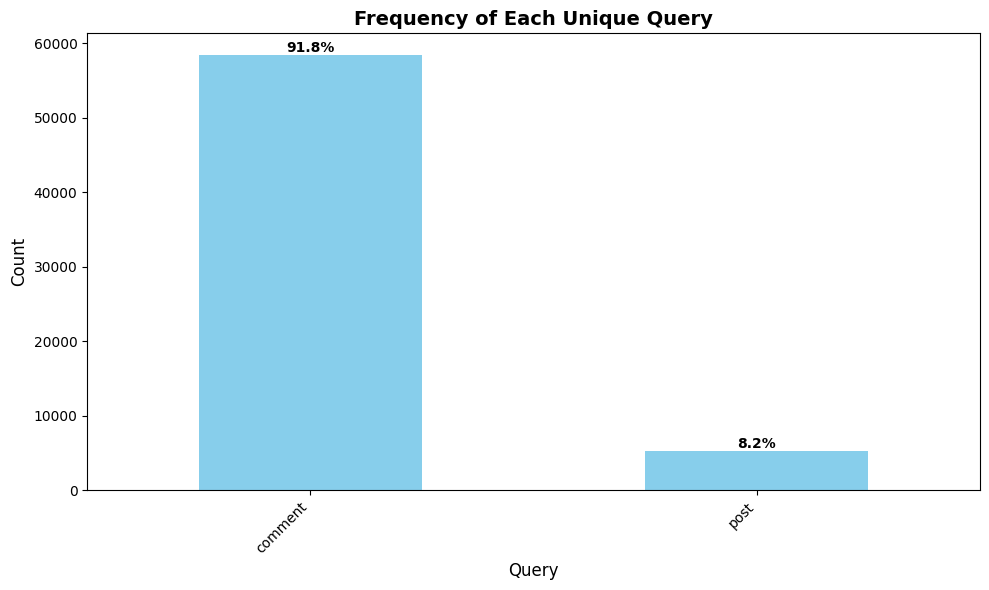

In [ ]:
query_counts = Dataset['source'].value_counts()

print("Unique queries:", Dataset['source'].unique())

total = query_counts.sum()

plt.figure(figsize=(10, 6))
ax = query_counts.plot(kind='bar', color='skyblue')

for i, count in enumerate(query_counts):
    percent = 100 * count / total
    ax.text(i, count + 0.5, f'{percent:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Frequency of Each Unique Query', fontsize=14, fontweight='bold')
plt.xlabel('Query', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### **Data Cleaning**

###### Removing the column with [Removed] and [Deleted] columns

In [ ]:
print("Row before cleaning:", len(Dataset))

Dataset = Dataset[~Dataset['text_raw'].isin(['[deleted]', '[removed]'])]
Dataset = Dataset[~Dataset['text_raw'].str.lower().str.strip().isin(['[deleted]', '[removed]'])]
Dataset = Dataset.reset_index(drop=True)

print("Remaining rows after cleaning:", len(Dataset))


Row before cleaning: 63668
Remaining rows after cleaning: 62500


###### Drop rows with missing or empty text

In [ ]:
print("Row before dropping missing/empty text:", len(Dataset))

Dataset = Dataset[Dataset['text_raw'].notnull() & (Dataset['text_raw'].str.strip() != '')]

print("Row After dropping missing/empty text:", len(Dataset))

Row before dropping missing/empty text: 62500
Row After dropping missing/empty text: 62499


###### **Let handle the NAN Value**

In [ ]:
print(Dataset.isnull().sum())

id                0
subreddit         0
created_utc       0
author         2847
text_raw          0
score             0
query             0
label             0
source            0
permalink         0
dtype: int64


###### We found 2,847 missing values in the *author* column. Since Reddit usernames are mostly anonymous and not useful for our training, we’ll simply drop this column.

In [ ]:
Dataset = Dataset.drop('author', axis=1)

In [ ]:
print(Dataset.isnull().sum())

id             0
subreddit      0
created_utc    0
text_raw       0
score          0
query          0
label          0
source         0
permalink      0
dtype: int64


###### Now our Author Column have been dropped and we currently don't have any nan in our Dataset.

###### Now, let’s clean our **text_raw** data by converting everything to lowercase, removing URLs and emojis, filtering out stopwords, and applying lemmatization to make the text neat and consistent!


In [ ]:
nltk.download("stopwords")
EN_STOP = set(stopwords.words("english"))
nlp = spacy.load("en_core_web_sm", exclude=["ner","parser","textcat"])

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower() # lowercase
    text = emoji.replace_emoji(text, replace=" ")   # remove emojis
    text = re.sub(r"http\S+|www\.\S+", " ", text)  # remove URLs
    text = re.sub(r"[^\w\s']", " ", text)          # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()
    return text

def lemmatize(text):
    doc = nlp(text)
    return " ".join(
        tok.lemma_ for tok in doc
        if tok.lemma_ not in EN_STOP and tok.is_alpha
    )

Dataset["text_clean"] = Dataset["text_raw"].apply(clean_text)
Dataset["text_lemma"] = Dataset["text_clean"].apply(lemmatize)

print("Cleaned & lemmatized posts and comments")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Cleaned & lemmatized posts and comments


###### We have successfully cleaned our dataset. Let **Preview** it and move on to the **Sentiment analysis**

In [ ]:
display(Dataset.head())

,id,subreddit,created_utc,text_raw,score,query,label,source,permalink,text_clean,text_lemma
0,1ltd0pl,UKJobs,1.751838e+09,Is there a correlation between unemployment an...,2,job dissatisfaction,dissatisfaction,post,https://www.reddit.com/r/UKJobs/comments/1ltd0...,is there a correlation between unemployment an...,correlation unemployment number job applicant ...
1,1l28f88,UKJobs,1.748947e+09,Me and a colleague have been shortlisted for s...,9,job dissatisfaction,dissatisfaction,post,https://www.reddit.com/r/UKJobs/comments/1l28f...,me and a colleague have been shortlisted for s...,I colleague shortlist role make I nervous coll...
2,1k1kp8i,UKJobs,1.744916e+09,Looking for advice Going to try condense this ...,2,job dissatisfaction,dissatisfaction,post,https://www.reddit.com/r/UKJobs/comments/1k1kp...,looking for advice going to try condense this ...,look advice go try condense much possible othe...
3,1of5hu1,UKJobs,1.761331e+09,Is the point of life to just work till your to...,10,hate my job,dissatisfaction,post,https://www.reddit.com/r/UKJobs/comments/1of5h...,is the point of life to just work till your to...,point life work till old bit context graduate ...
4,1oesu9x,UKJobs,1.761297e+09,Handing in notice when staff are off? Hello ev...,9,hate my job,dissatisfaction,post,https://www.reddit.com/r/UKJobs/comments/1oesu...,handing in notice when staff are off hello eve...,hand notice staff hello everyone I really crap...


In [ ]:
Dataset.to_csv('2025_JOB_Dissatisfaction_Cleaned.csv', index=False)

### **Sentiment Analysis**

##### Sentiment analysis is a natural language processing technique that identifies and classifies emotions or opinions in text as positive, negative, or neutral. It helps organizations understand customer feedback, social media posts, or reviews. Using machine learning, it automates the process of interpreting human emotions for better decision-making and communication.


### **Reddit Label**

###### Let’s rename our sentiment labels for clarity — changing *satisfaction* to **Positive** and *dissatisfaction* to **Negative**, then count how many posts fall into each category

In [ ]:
Dataset['label'] = Dataset['label'].replace('dissatisfaction', 'Negative')
Dataset['label'] = Dataset['label'].replace('satisfaction', 'Positive')
Reddit_Label = Dataset["label"].value_counts().sort_index()
print(Reddit_Label)

label
Negative    47716
Positive    14783
Name: count, dtype: int64


###### Let’s visualize the number of posts for each sentiment label with a simple bar chart to see how our data is distributed

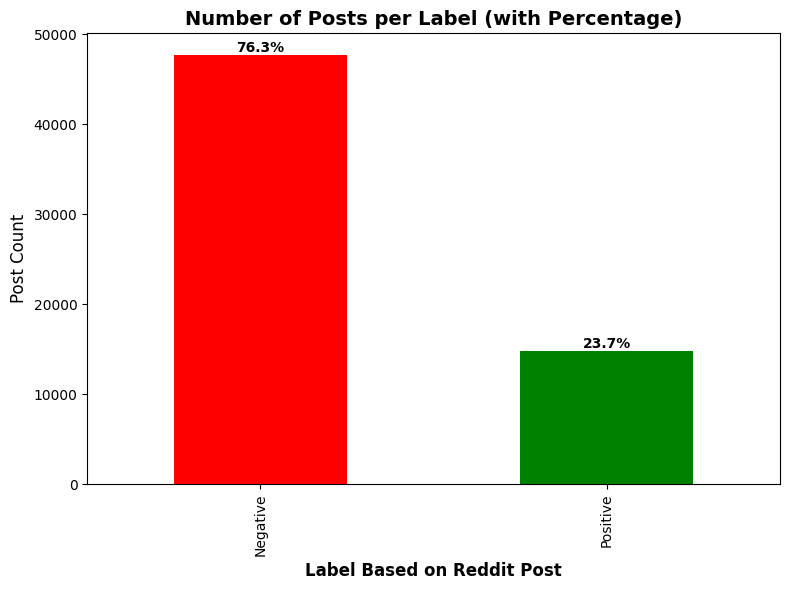

In [ ]:
plt.figure(figsize=(8, 6))
ax = Reddit_Label.plot(kind="bar", color=['red', 'green'])
total = Reddit_Label.sum()
for i, value in enumerate(Reddit_Label):
    percent = 100 * value / total
    ax.text(i, value + 0.5, f'{percent:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.title("Number of Posts per Label (with Percentage)", fontsize=14, fontweight='bold')
plt.xlabel("Label Based on Reddit Post", fontsize=12, fontweight="bold")
plt.ylabel("Post Count", fontsize=12)
plt.tight_layout()
plt.show()

#### **Rule Based Using Vader**

###### VADER (Valence Aware Dictionary and sEntiment Reasoner) is a rule-based sentiment analysis tool designed for social media text. It uses a pre-built lexicon and considers word intensity, punctuation, capitalization, and emojis to determine sentiment scores positive, negative, neutral, and compound. Making it accurate for short, informal, and expressive online language.


###### Make a VADER analyzer to check how positive or negative text is

In [ ]:
analyzer = SentimentIntensityAnalyzer()

###### Let’s use the **VADER** sentiment analyzer to score each post’s emotional tone, then classify it as **Positive**, **Negative**, or **Neutral** based on the compound sentiment score.


In [ ]:
Dataset['compound'] = Dataset['text_lemma'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [ ]:
display(Dataset.head())

,id,subreddit,created_utc,text_raw,score,query,label,source,permalink,text_clean,text_lemma,compound
0,1ltd0pl,UKJobs,1.751838e+09,Is there a correlation between unemployment an...,2,job dissatisfaction,Negative,post,https://www.reddit.com/r/UKJobs/comments/1ltd0...,is there a correlation between unemployment an...,correlation unemployment number job applicant ...,-0.9201
1,1l28f88,UKJobs,1.748947e+09,Me and a colleague have been shortlisted for s...,9,job dissatisfaction,Negative,post,https://www.reddit.com/r/UKJobs/comments/1l28f...,me and a colleague have been shortlisted for s...,I colleague shortlist role make I nervous coll...,0.2516
2,1k1kp8i,UKJobs,1.744916e+09,Looking for advice Going to try condense this ...,2,job dissatisfaction,Negative,post,https://www.reddit.com/r/UKJobs/comments/1k1kp...,looking for advice going to try condense this ...,look advice go try condense much possible othe...,0.5367
3,1of5hu1,UKJobs,1.761331e+09,Is the point of life to just work till your to...,10,hate my job,Negative,post,https://www.reddit.com/r/UKJobs/comments/1of5h...,is the point of life to just work till your to...,point life work till old bit context graduate ...,0.9951
4,1oesu9x,UKJobs,1.761297e+09,Handing in notice when staff are off? Hello ev...,9,hate my job,Negative,post,https://www.reddit.com/r/UKJobs/comments/1oesu...,handing in notice when staff are off hello eve...,hand notice staff hello everyone I really crap...,0.8664


###### We have a new field called compound which was gotten from Vader. Let use the compound score to group their sentiment. According to Vader documentation. positive sentiment: compound score >= 0.05, neutral sentiment: (compound score > -0.05) and (compound score < 0.05), negative sentiment: compound score <= -0.05  

In [ ]:
Dataset['vader_sentiment'] = Dataset['vader_sentiment'] = Dataset['compound'].apply(lambda c: ('Positive' if c >= 0.05 else 'Negative' if c <= -0.05 else 'Neutral'))

###### Now we have sucessfully added the compound score and also a new column called vader sentiment which categorize them into Positive, Negative and Neutral

###### Let plot a bar chart showing how many posts are **Positive**, **Neutral**, or **Negative** according to VADER

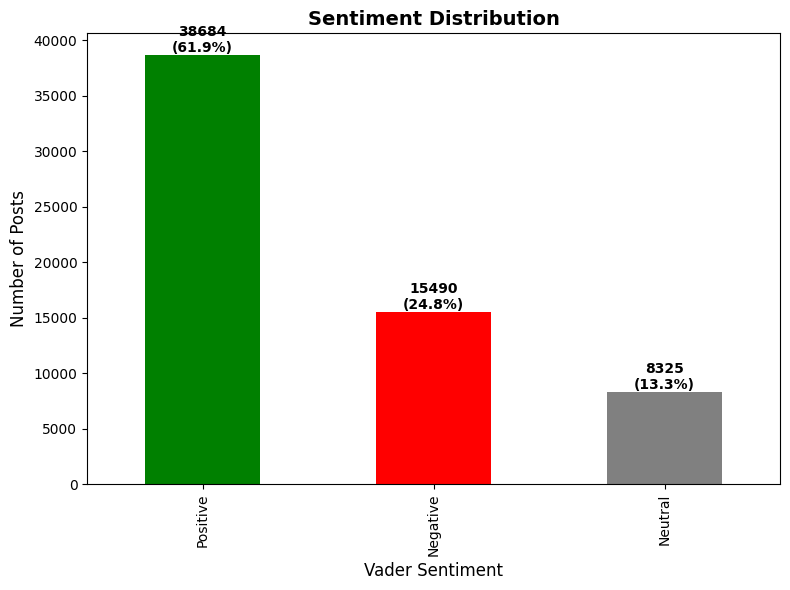

In [ ]:
sentiment_counts = Dataset['vader_sentiment'].value_counts()
total = sentiment_counts.sum()
plt.figure(figsize=(8, 6))
ax = sentiment_counts.plot(kind='bar', color=['green', 'red', 'gray'])
for i, value in enumerate(sentiment_counts):
    percent = 100 * value / total
    ax.text(i, value + 0.5,
            f'{value}\n({percent:.1f}%)',
            ha='center', va='bottom',
            fontsize=10, fontweight='bold')

plt.title('Sentiment Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Vader Sentiment', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
plt.tight_layout()
plt.show()

###### let plot an histogram to show how the VADER compound scores are spread across all reviews

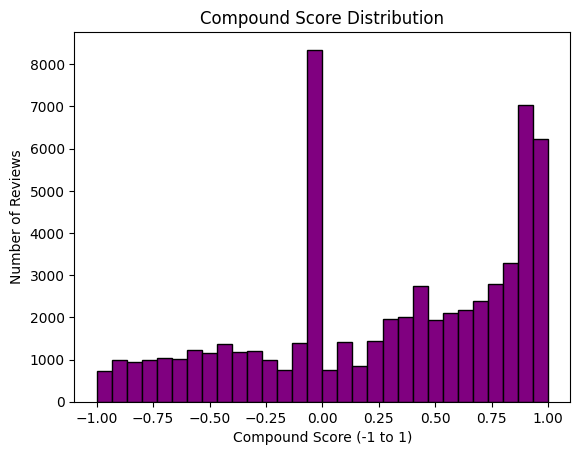

In [ ]:
plt.hist(Dataset['compound'], bins=30, color='purple', edgecolor='black')
plt.title('Compound Score Distribution')
plt.xlabel('Compound Score (-1 to 1)')
plt.ylabel('Number of Reviews')
plt.show()

###### Let create a word cloud of the most common words from positive posts

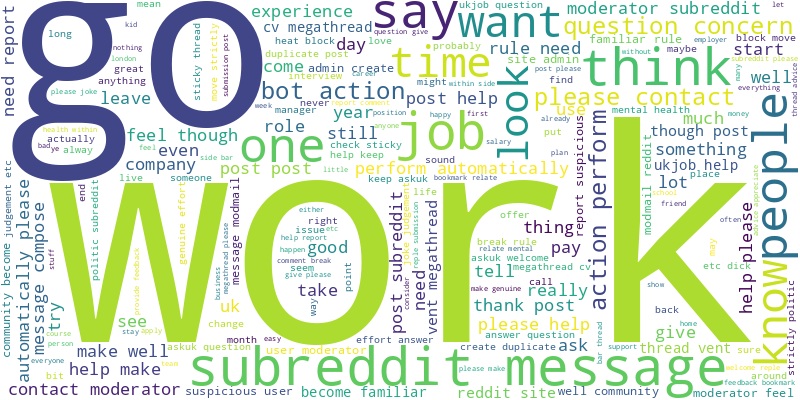

In [ ]:
pos_text = " ".join(Dataset[Dataset['vader_sentiment'] == 'Positive']['text_lemma'])
WordCloud(width=800, height=400, background_color='white').generate(pos_text).to_image()

WordCloud for the Negative word as well

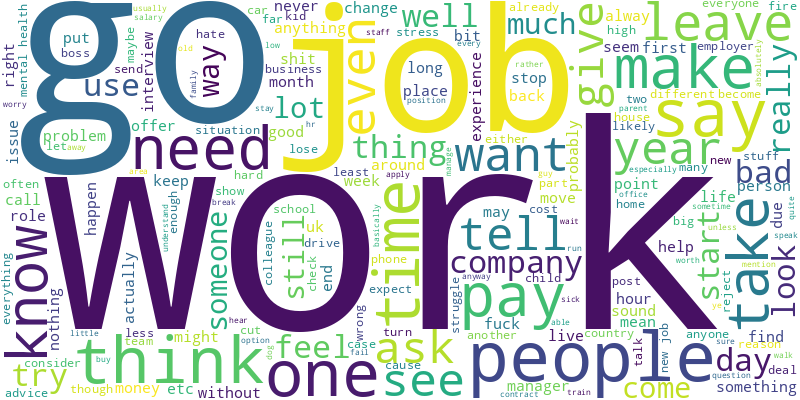

In [ ]:
pos_text = " ".join(Dataset[Dataset['vader_sentiment'] == 'Negative']['text_lemma'])
WordCloud(width=800, height=400, background_color='white').generate(pos_text).to_image()

###### Word Cloud for Neutral

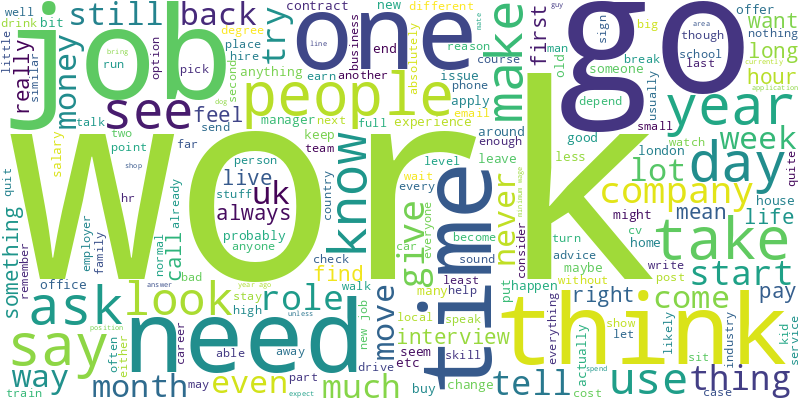

In [ ]:
pos_text = " ".join(Dataset[Dataset['vader_sentiment'] == 'Neutral']['text_lemma'])
WordCloud(width=800, height=400, background_color='white').generate(pos_text).to_image()

###### Let print the most positive and most negative reviews based on the highest and lowest VADER compound scores

In [ ]:
print("Most Positive Review:")
print(Dataset.loc[Dataset['compound'].idxmax(), 'text_lemma'])

print("\nMost Negative Review:")
print(Dataset.loc[Dataset['compound'].idxmin(), 'text_lemma'])

Most Positive Review:
nhs england really fail I senior doctor nhs one thing I learn issue face result frontline staff fail roll sleeve try good rather much chaos stress endless crisis read daily trace back series decision make senior leadership team nhs england nhse leadership choice ripple across every trust every specialism nearly every colleague I meet shape daily experience doctor nurse ally health professional way often detrimental patient care nhs england leadership either lobby government particular policy task turn government policy reality yet never hold accountable secretary state health social care catch disproportionate amount flak contract erosion continuity care back new contract impose resident doctor market least public upgrade would introduce seven day nhs ensure consistent coverage throughout weekend practice political optic genuine improvement patient outcome perspective tangible change doctor suddenly find spread thinly across day rota pattern become erratic one gre

#### **Rule Based Using TextBlob**

###### TextBlob is a Python library for processing textual data. It provides simple APIs for tasks like sentiment analysis, part-of-speech tagging, and noun phrase extraction. Using pre-trained models, TextBlob assigns polarity (positive or negative) and subjectivity scores, making it beginner-friendly for quickly analyzing text and building natural language processing applications.


###### Let's download TextBlob's required NLTK corpora (needed for sentiment analysis, translation, etc.)

In [ ]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


###### Let calculate TextBlob sentiment scores for each text (polarity and subjectivity) and also display the first few rows to check the new columns

In [ ]:
Dataset['polarity'] = Dataset['text_lemma'].apply(lambda x: TextBlob(x).sentiment.polarity)
Dataset['subjectivity'] = Dataset['text_lemma'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

print(Dataset.head())

        id subreddit   created_utc  \
0  1ltd0pl    UKJobs  1.751838e+09   
1  1l28f88    UKJobs  1.748947e+09   
2  1k1kp8i    UKJobs  1.744916e+09   
3  1of5hu1    UKJobs  1.761331e+09   
4  1oesu9x    UKJobs  1.761297e+09   

                                            text_raw  score  \
0  Is there a correlation between unemployment an...      2   
1  Me and a colleague have been shortlisted for s...      9   
2  Looking for advice Going to try condense this ...      2   
3  Is the point of life to just work till your to...     10   
4  Handing in notice when staff are off? Hello ev...      9   

                 query     label source  \
0  job dissatisfaction  Negative   post   
1  job dissatisfaction  Negative   post   
2  job dissatisfaction  Negative   post   
3          hate my job  Negative   post   
4          hate my job  Negative   post   

                                           permalink  \
0  https://www.reddit.com/r/UKJobs/comments/1ltd0...   
1  https://www.reddit

###### Let's define a function to label TextBlob polarity scores as Positive, Negative, or Neutral

In [ ]:
def label_sentiment(score):
    if score > 0:
        return "Positive"
    elif score < 0:
        return "Negative"
    else:
        return "Neutral"

###### Apply the label_sentiment function to classify each TextBlob polarity score as Positive, Negative, or Neutral

In [ ]:
Dataset["Blob_Sentiment"] = Dataset["polarity"].apply(label_sentiment)

###### Let's count how many posts fall into each TextBlob sentiment category (Positive, Negative, Neutral)

In [ ]:
sentiment_counts = Dataset["Blob_Sentiment"].value_counts()

In [ ]:
print(sentiment_counts)

Blob_Sentiment
Positive    38212
Negative    14401
Neutral      9886
Name: count, dtype: int64


###### Let plot a bar chart showing how many reviews are Positive, Neutral, or Negative based on TextBlob sentiment

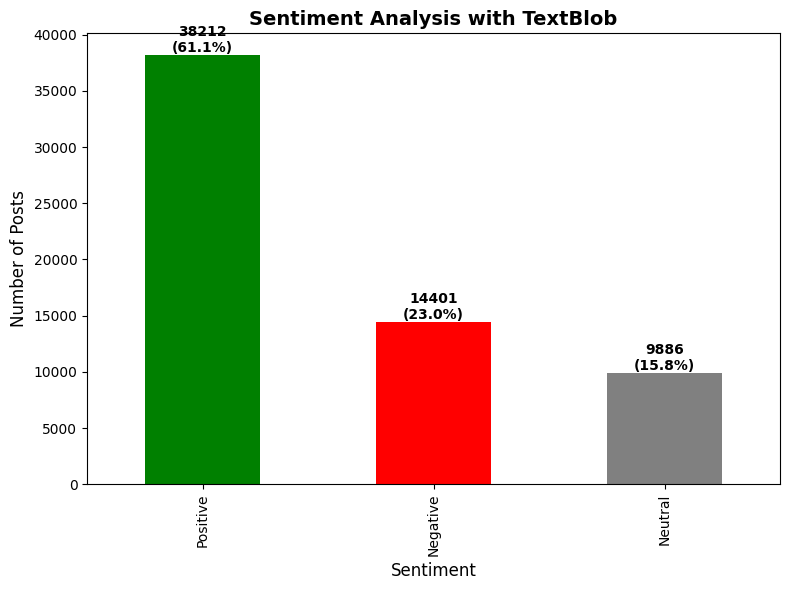

In [ ]:
sentiment_counts = sentiment_counts
total = sentiment_counts.sum()
plt.figure(figsize=(8, 6))
ax = sentiment_counts.plot(kind='bar', color=['green', 'red', 'gray'])
for i, value in enumerate(sentiment_counts):
    percent = 100 * value / total
    ax.text(i, value + 0.5,
            f'{value}\n({percent:.1f}%)',
            ha='center', va='bottom',
            fontsize=10, fontweight='bold')

plt.title('Sentiment Analysis with TextBlob', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
plt.tight_layout()
plt.show()

#### **Using Transformer**

In [ ]:
MODEL_NAME = "spacesedan/reddit-sentiment-analysis-longformer"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

clf = pipeline(
    task="sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    truncation=True,
    max_length=128,
)

def _batch_hf_sentiment(text_series: pd.Series, batch_size: int = 64) -> pd.DataFrame:
    """
    Run HF sentiment in batches over a pandas Series of text and return
    a DataFrame with columns: neg, neu, pos, sentiment (string label).
    """
    text_series = text_series.fillna("").astype(str)

    outputs = clf(list(text_series), batch_size=batch_size)

    rows = []
    for scores in outputs:
        label_to_score = {d["label"].lower(): float(d["score"]) for d in scores}
        top_label = max(label_to_score, key=label_to_score.get)

        rows.append({
            "neg": label_to_score.get("negative"),
            "neu": label_to_score.get("neutral"),
            "pos": label_to_score.get("positive"),
            "sentiment": top_label
        })

    return pd.DataFrame(rows, index=text_series.index)

Dataset_scores = _batch_hf_sentiment(Dataset["text_lemma"])

Dataset = pd.concat([Dataset, Dataset_scores], axis=1)

print(Dataset[["text_lemma", "sentiment"]].head())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Initializing global attention on CLS token...
Input ids are automatically padded to be a multiple of `config.attention_window`: 512


                                          text_lemma      sentiment
0  correlation unemployment number job applicant ...        neutral
1  I colleague shortlist role make I nervous coll...       positive
2  look advice go try condense much possible othe...  very negative
3  point life work till old bit context graduate ...  very positive
4  hand notice staff hello everyone I really crap...       positive


##### **Visualization for Transformer**

In [ ]:
display(Dataset)

,id,subreddit,created_utc,text_raw,score,query,label,source,permalink,text_clean,text_lemma,compound,vader_sentiment,polarity,subjectivity,Blob_Sentiment,neg,neu,pos,sentiment
0,1ltd0pl,UKJobs,1.751838e+09,Is there a correlation between unemployment an...,2,job dissatisfaction,Negative,post,https://www.reddit.com/r/UKJobs/comments/1ltd0...,is there a correlation between unemployment an...,correlation unemployment number job applicant ...,-0.9201,Negative,0.034020,0.491580,Positive,0.131145,0.563207,0.020800,neutral
1,1l28f88,UKJobs,1.748947e+09,Me and a colleague have been shortlisted for s...,9,job dissatisfaction,Negative,post,https://www.reddit.com/r/UKJobs/comments/1l28f...,me and a colleague have been shortlisted for s...,I colleague shortlist role make I nervous coll...,0.2516,Positive,0.262500,0.466667,Positive,0.028519,0.104343,0.741284,positive
2,1k1kp8i,UKJobs,1.744916e+09,Looking for advice Going to try condense this ...,2,job dissatisfaction,Negative,post,https://www.reddit.com/r/UKJobs/comments/1k1kp...,looking for advice going to try condense this ...,look advice go try condense much possible othe...,0.5367,Positive,-0.022313,0.379697,Negative,0.101022,0.275912,0.036717,very negative
3,1of5hu1,UKJobs,1.761331e+09,Is the point of life to just work till your to...,10,hate my job,Negative,post,https://www.reddit.com/r/UKJobs/comments/1of5h...,is the point of life to just work till your to...,point life work till old bit context graduate ...,0.9951,Positive,0.051861,0.577532,Positive,0.066344,0.011277,0.404963,very positive
4,1oesu9x,UKJobs,1.761297e+09,Handing in notice when staff are off? Hello ev...,9,hate my job,Negative,post,https://www.reddit.com/r/UKJobs/comments/1oesu...,handing in notice when staff are off hello eve...,hand notice staff hello everyone I really crap...,0.8664,Positive,-0.092264,0.435379,Negative,0.044916,0.011419,0.754965,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62495,mpohzj4,recruitinghell,1.745943e+09,Companies cheat and auto reject anyone without...,4,flexible working,Positive,comment,https://www.reddit.com/r/recruitinghell/commen...,companies cheat and auto reject anyone without...,company cheat auto reject anyone without match...,-0.2960,Negative,0.250000,0.300000,Positive,0.013302,0.672179,0.006329,neutral
62496,mpo87od,recruitinghell,1.745940e+09,"Good luck, OP. Sounds just like what happened...",3,flexible working,Positive,comment,https://www.reddit.com/r/recruitinghell/commen...,good luck op sounds just like what happened to...,good luck op sound like happen I gettign stem ...,0.8126,Positive,0.550000,0.500000,Positive,0.012237,0.213887,0.759692,positive
62497,mcf4fyu,recruitinghell,1.739389e+09,The discord for our subreddit can be found her...,1,flexible working,Positive,comment,https://www.reddit.com/r/recruitinghell/commen...,the discord for our subreddit can be found her...,discord subreddit find feel free join realtime...,0.6249,Positive,0.250000,0.450000,Positive,0.024111,0.896784,0.007900,neutral
62498,mcimio9,recruitinghell,1.739433e+09,Yeah it's terrible. I'm in London and have bee...,2,flexible working,Positive,comment,https://www.reddit.com/r/recruitinghell/commen...,yeah it's terrible i'm in london and have been...,yeah terrible I london look since june intervi...,-0.2263,Negative,-0.500000,0.500000,Negative,0.067321,0.018909,0.531621,positive


###### Because the Transformer we used is 5-point sentiment classification. we need to merge Very positive with postive and very Negative with Negative and plot our chart

In [ ]:
Dataset['sentiment'] = Dataset['sentiment'].replace('negative', 'Negative')
Dataset['sentiment'] = Dataset['sentiment'].replace('positive', 'Positive')
Dataset['sentiment'] = Dataset['sentiment'].replace('neutral', 'Neutral')
Dataset['sentiment'] = Dataset['sentiment'].replace('very negative', 'Negative')
Dataset['sentiment'] = Dataset['sentiment'].replace('very positive', 'Positive')

In [ ]:
Dataset['sentiment'].value_counts()

,count
sentiment,
Neutral,36433
Positive,13207
Negative,12859


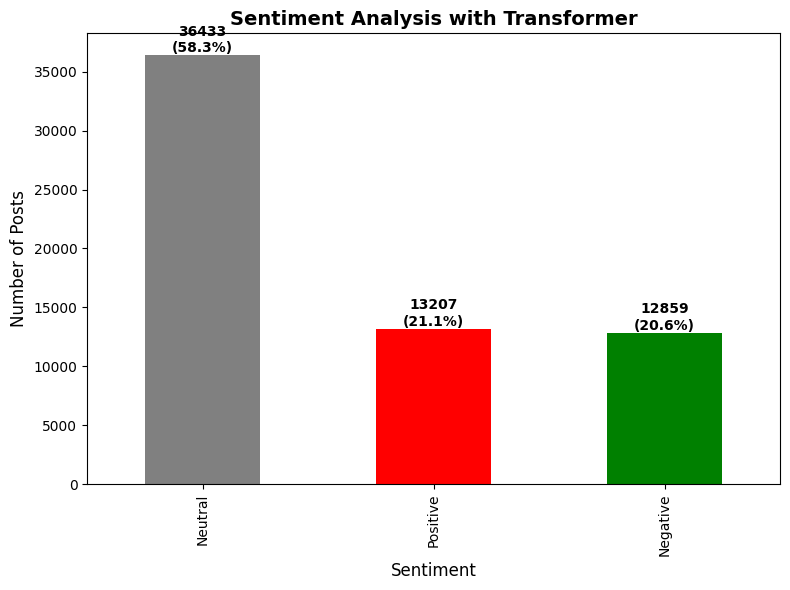

In [ ]:
sentiment_counts = Dataset['sentiment'].value_counts()
total = sentiment_counts.sum()
plt.figure(figsize=(8, 6))
ax = sentiment_counts.plot(kind='bar', color=['gray', 'red', 'green'])
for i, value in enumerate(sentiment_counts):
    percent = 100 * value / total
    ax.text(i, value + 0.5,
            f'{value}\n({percent:.1f}%)',
            ha='center', va='bottom',
            fontsize=10, fontweight='bold')

plt.title('Sentiment Analysis with Transformer', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
plt.tight_layout()
plt.show()

### **Comparison between Vader, TextBlob, Reddit Label and Transformer**

###### VADER handles social media text and slang better, while TextBlob is simpler, offering broader NLP features but less accurate on informal language.

###### Let's Compare the number of Positive, Neutral, and Negative sentiments between TextBlob and VADER and also Combine both results into one DataFrame for easy comparison then display them

In [ ]:
textblob_counts = Dataset["Blob_Sentiment"].value_counts()
vader_counts = Dataset["vader_sentiment"].value_counts()
Transformer_counts = Dataset["sentiment"].value_counts()

comparison = pd.DataFrame({
    "TextBlob": textblob_counts,
    "VADER": vader_counts,
    "Transformer(twitter-roberta-base-sentiment-latest)": Transformer_counts,
    "Reddit Label": Dataset["label"].value_counts()

}).fillna(0)

display(comparison)

,TextBlob,VADER,Transformer(twitter-roberta-base-sentiment-latest),Reddit Label
Negative,14401,15490,12859,47716.0
Neutral,9886,8325,36433,0.0
Positive,38212,38684,13207,14783.0


###### Plotting a side-by-side bar chart to compare TextBlob and VADER sentiment results.

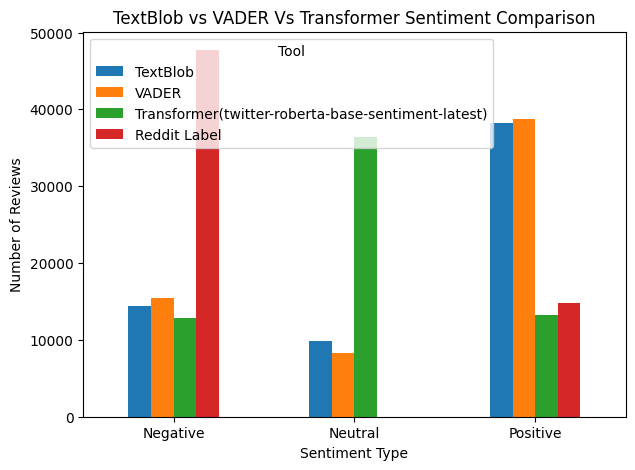

In [ ]:
comparison.plot(kind="bar", figsize=(7,5))
plt.title("TextBlob vs VADER Vs Transformer Sentiment Comparison")
plt.xlabel("Sentiment Type")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.legend(title="Tool")
plt.show()

#### **Model Agreement**

###### Let’s check how consistent our sentiment models are! We’ll see what percentage of samples all four models agree on and how often at least two models share the same sentiment.

In [ ]:
from collections import Counter

Dataset["all_agree"] = (
    (Dataset["vader_sentiment"] == Dataset["Blob_Sentiment"]) &
    (Dataset["vader_sentiment"] == Dataset["sentiment"]) &
    (Dataset["vader_sentiment"] == Dataset["label"])
)

all_agree_rate = Dataset['all_agree'].mean()

def majority_agreement(row):
    votes = [row['vader_sentiment'], row['Blob_Sentiment'], row['sentiment'], row['label']]
    return len(set(votes)) < 3

Dataset['two_or_more_agree'] = Dataset.apply(majority_agreement, axis=1)
two_plus_agree_rate = Dataset['two_or_more_agree'].mean()

print(f"All 4 labelling models agree on {all_agree_rate:.2%} of samples")
print(f"At least two models agree on {two_plus_agree_rate:.2%} of samples")

All 4 labelling models agree on 7.94% of samples
At least two models agree on 62.81% of samples


#### **Average confidence**

###### Let’s evaluate how confident each sentiment model is in its predictions. We calculate absolute confidence scores for **VADER**, **TextBlob**, and the **Transformer model**, then compare their average confidence levels to see which model shows the strongest overall certainty.

In [ ]:
# VADER and TextBlob confidence (absolute values)
Dataset['vader_strength'] = Dataset['compound'].abs()
Dataset['textblob_strength'] = Dataset['polarity'].abs()

# Transformer confidence = highest probability among negative, neutral, positive
Dataset['transformer_strength'] = Dataset[['neg', 'neu', 'pos']].max(axis=1)

# Print average confidence for all three
print("Average VADER confidence:", Dataset['vader_strength'].mean())
print("Average TextBlob confidence:", Dataset['textblob_strength'].mean())
print("Average Transformer confidence:", Dataset['transformer_strength'].mean())

Average VADER confidence: 0.5323823773180371
Average TextBlob confidence: 0.1695275676628761
Average Transformer confidence: 0.6388095717575665


###### Let’s visualize the average confidence levels of our three sentiment models — **VADER**, **TextBlob**, and **Transformer** — using a clear bar chart to see which model makes predictions with the most certainty!

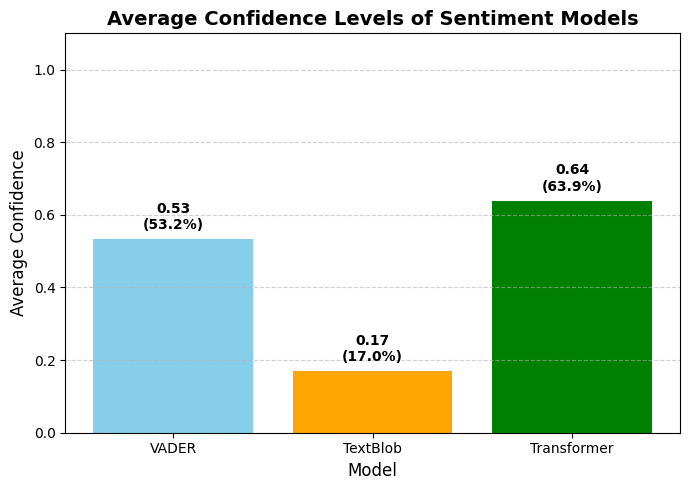

In [ ]:
avg_confidences = {
    'VADER': Dataset['vader_strength'].mean(),
    'TextBlob': Dataset['textblob_strength'].mean(),
    'Transformer': Dataset['transformer_strength'].mean()
}

plt.figure(figsize=(7, 5))
ax = plt.bar(avg_confidences.keys(), avg_confidences.values(),
             color=['skyblue', 'orange', 'green'])

for i, (model, value) in enumerate(avg_confidences.items()):
    percent = value * 100
    plt.text(i, value + 0.02,
             f"{value:.2f}\n({percent:.1f}%)",
             ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.title("Average Confidence Levels of Sentiment Models", fontsize=14, fontweight='bold')
plt.xlabel("Model", fontsize=12)
plt.ylabel("Average Confidence", fontsize=12)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

###### The comparison of average confidence levels reveals that the Transformer model produces the strongest and most confident sentiment predictions, followed by VADER, while TextBlob shows the weakest overall confidence on the Reddit dataset.

#### **Saving the Sentiment Labelling Dataset**

In [ ]:
Dataset.to_csv('2025_JOB_Dissatisfaction_Sentiment.csv', index=False)

#### **Traditional Model**

###### We will start by training with traditional model. We are using **Naive Bayes & SVM**

###### Let make a copy of our Dataset

In [ ]:
Dataframe = Dataset.copy()

#### **Naive Bayes**

#### **Naive Bayes Function**

###### So here, we’re building a balanced sentiment model. Basically, we convert our text into **TF-IDF features**, change the sentiment labels into numbers, handle **class imbalance with class weight**, train a **Naive Bayes model**, and then test how accurate it is.

In [ ]:
def train_sentiment_model(dataframe, sentiment_col, use_class_weight=True):
    """
    Train a TF-IDF + MultinomialNB sentiment classifier.
    If use_class_weight=True, compute balanced class weights and pass them
    as per-sample weights to MultinomialNB.fit().
    """
    # Map sentiment labels to numeric values
    label_map = {'Negative': 0, 'Positive': 1, 'Neutral': 2}
    dataframe['label_mapped'] = dataframe[sentiment_col].map(label_map)

    # Text → TF-IDF features (unigrams + bigrams)
    tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
    X = tfidf.fit_transform(dataframe['text_lemma'])
    y = dataframe['label_mapped']

    # Train/test split (stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Compute sample weights from class weights
    sample_weight_train = None
    if use_class_weight:
        classes = np.unique(y_train)
        weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
        class_weight_dict = {c: w for c, w in zip(classes, weights)}
        # Map each training example's label to its class weight
        sample_weight_train = y_train.map(class_weight_dict).to_numpy()

        # show weights for transparency
        inv_label_map = {0: 'Negative', 1: 'Positive', 2: 'Neutral'}
        pretty_weights = {inv_label_map[c]: round(float(w), 4) for c, w in class_weight_dict.items()}
        print("Class weights (balanced):", pretty_weights)

    # 5) Train MultinomialNB
    nb = MultinomialNB()
    nb.fit(X_train, y_train, sample_weight=sample_weight_train)

    # 6) Predict & evaluate
    y_pred = nb.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", round(accuracy, 4))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive', 'Neutral']))
    print("\nConfusion Matrix (rows=true, cols=pred):")
    print(confusion_matrix(y_test, y_pred))

    return nb, tfidf, accuracy

###### We’re going to train our sentiment models using the **Naive Bayes** algorithm to compare their performance. The idea is to feed in the sentiment outputs from **VADER**, **TextBlob**, and the **Transformer model** separately, and then check which one gives us the best accuracy and overall results. By doing this, we’ll be able to see which sentiment detection method works best with our dataset and produces the most reliable predictions.


#### **Vader with Naive Bayes**

In [ ]:
Vader_Naive_Bayes = train_sentiment_model(Dataframe, 'vader_sentiment')

#### **Transformer with Naive Bayes**

In [ ]:
Transformer_Naive_Bayes = train_sentiment_model(Dataframe, 'sentiment')

Class weights (balanced): {'Negative': 1.6201, 'Positive': 1.5774, 'Neutral': 0.5718}
Accuracy: 0.5407

Classification Report:
              precision    recall  f1-score   support

    Negative       0.31      0.89      0.46      2572
    Positive       0.79      0.32      0.46      2641
     Neutral       0.87      0.50      0.63      7287

    accuracy                           0.54     12500
   macro avg       0.66      0.57      0.52     12500
weighted avg       0.74      0.54      0.56     12500


Confusion Matrix (rows=true, cols=pred):
[[2292   31  249]
 [1513  853  275]
 [3484  189 3614]]


#### **Text Blob with Naive Bayes**

In [ ]:
TextBlob_Naive_Bayes = train_sentiment_model(Dataframe, 'Blob_Sentiment')

Class weights (balanced): {'Negative': 1.4466, 'Positive': 0.5452, 'Neutral': 2.1073}
Accuracy: 0.5462

Classification Report:
              precision    recall  f1-score   support

    Negative       0.36      0.91      0.52      2880
    Positive       0.96      0.36      0.52      7643
     Neutral       0.61      0.75      0.67      1977

    accuracy                           0.55     12500
   macro avg       0.64      0.67      0.57     12500
weighted avg       0.77      0.55      0.54     12500


Confusion Matrix (rows=true, cols=pred):
[[2610   44  226]
 [4188 2735  720]
 [ 420   74 1483]]


##### **Comparing the naive bayes result for the 4 labelling**

###### Let’s visualize how well each sentiment model performed after training with **Naive Bayes** This bar chart compares the accuracy of **VADER**, **TextBlob**, and **Transformer** labelling to see which one delivers the best overall results.

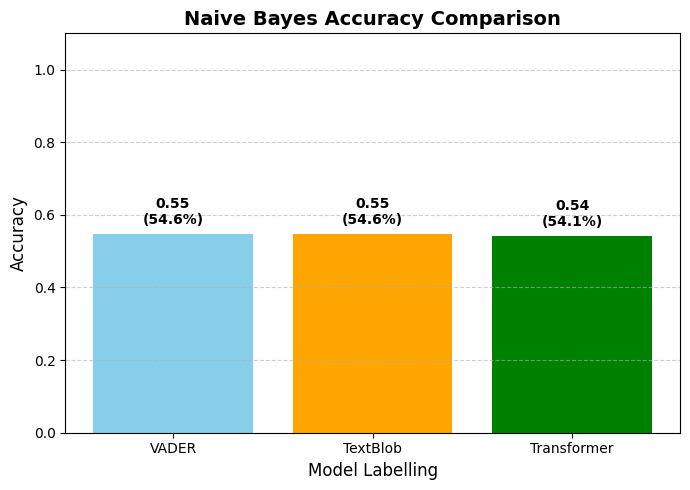

In [ ]:
Naive_Result = {
    'VADER': Vader_Naive_Bayes[2],
    'TextBlob': TextBlob_Naive_Bayes[2],
    'Transformer': Transformer_Naive_Bayes[2]
}

plt.figure(figsize=(7, 5))
ax = plt.bar(Naive_Result.keys(), Naive_Result.values(),
             color=['skyblue', 'orange', 'green'])

for i, (model, value) in enumerate(Naive_Result.items()):
    percent = value * 100
    plt.text(i, value + 0.02,
             f"{value:.2f}\n({percent:.1f}%)",  # shows both
             ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.title("Naive Bayes Accuracy Comparison", fontsize=14, fontweight='bold')
plt.xlabel("Model Labelling", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

###### Let’s neatly display our Naive Bayes accuracy results in a table using a DataFrame, so we can easily compare **VADER**, **TextBlob**, and **Transformer** model performances side by side.

In [ ]:
result_naive = pd.DataFrame(Naive_Result, index=[0])
display(result_naive)

,VADER,TextBlob,Transformer
0,0.546,0.54624,0.54072


##### **SVM (Support Vector Machine)**

###### We’re now training a sentiment model using **Support Vector Machine (LinearSVC)** instead of Naive Bayes. We map the labels, turn the cleaned text into TF-IDF features, split the data, train the SVM with class balancing, and then check accuracy, report, and confusion matrix.

In [ ]:
def train_svm_sentiment_model(dataframe, sentiment_col):
    label_map = {'Negative': 0, 'Positive': 1, 'Neutral': 2}
    dataframe['label_mapped'] = dataframe[sentiment_col].map(label_map)

    tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
    X = tfidf.fit_transform(dataframe['text_lemma'])
    y = dataframe['label_mapped']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    svm = LinearSVC(class_weight='balanced', random_state=42)
    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", round(accuracy, 4))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_map.keys()))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return svm, tfidf, accuracy

#### **Vader with SVM**

In [ ]:
Vader_SVM = train_svm_sentiment_model(Dataframe, 'vader_sentiment')

Accuracy: 0.8742

Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.82      0.82      3098
    Positive       0.94      0.91      0.92      7737
     Neutral       0.71      0.83      0.77      1665

    accuracy                           0.87     12500
   macro avg       0.82      0.85      0.84     12500
weighted avg       0.88      0.87      0.88     12500


Confusion Matrix:
[[2527  319  252]
 [ 405 7012  320]
 [ 165  111 1389]]


#### **Transformer with SVM**

In [ ]:
Transformer_SVM = train_svm_sentiment_model(Dataframe, 'sentiment')

Accuracy: 0.8273

Classification Report:
              precision    recall  f1-score   support

    Negative       0.68      0.65      0.66      2572
    Positive       0.85      0.82      0.83      2641
     Neutral       0.87      0.89      0.88      7287

    accuracy                           0.83     12500
   macro avg       0.80      0.79      0.79     12500
weighted avg       0.83      0.83      0.83     12500


Confusion Matrix:
[[1669  176  727]
 [ 215 2157  269]
 [ 569  203 6515]]


#### **Text Blob with SVM**

In [ ]:
TextBlob_SVM = train_svm_sentiment_model(Dataframe, 'Blob_Sentiment')

Accuracy: 0.9183

Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.87      0.86      2880
    Positive       0.96      0.93      0.94      7643
     Neutral       0.86      0.96      0.90      1977

    accuracy                           0.92     12500
   macro avg       0.89      0.92      0.90     12500
weighted avg       0.92      0.92      0.92     12500


Confusion Matrix:
[[2500  258  122]
 [ 361 7086  196]
 [  44   40 1893]]


#### **Comparing the 4 result for SVM**

###### Let’s visualize how each sentiment model performed when trained with **SVM**! This bar chart compares the accuracy of **VADER**, **TextBlob**, and **Transformer** labelling, helping us see which one delivers the highest performance with the SVM classifier.


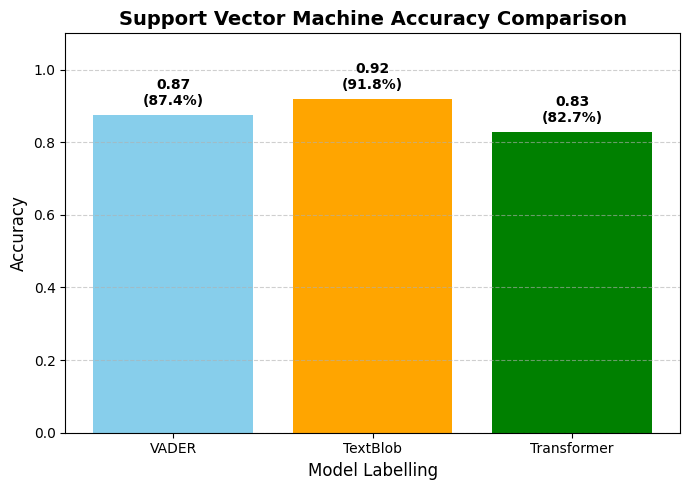

In [ ]:
SVM_Result = {
    'VADER': Vader_SVM[2],
    'TextBlob': TextBlob_SVM[2],
    'Transformer': Transformer_SVM[2]
}

plt.figure(figsize=(7, 5))
ax = plt.bar(SVM_Result.keys(), SVM_Result.values(),
             color=['skyblue', 'orange', 'green'])

for i, (model, value) in enumerate(SVM_Result.items()):
    percent = value * 100
    plt.text(i, value + 0.02,
             f"{value:.2f}\n({percent:.1f}%)",  # shows both
             ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

plt.title("Support Vector Machine Accuracy Comparison", fontsize=14, fontweight='bold')
plt.xlabel("Model Labelling", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
result_svm = pd.DataFrame(SVM_Result, index=[0])
display(result_svm)

,VADER,TextBlob,Transformer
0,0.87424,0.91832,0.82728


### **Deep Learning Model**

###### We’re going to build two deep learning models **BERT** and a **CNN for text** to train and compare performance across the **VADER**, **TextBlob**, and **Transformer** sentiment datasets.

###### Let make the copy of the dataset

In [ ]:
df = Dataset.copy()

#### **CNN for Text**

###### We’re training a **CNN-based deep learning model** for sentiment analysis. The text is tokenized, padded, and converted into embeddings so the model can learn meaningful word patterns. Using convolutional and dense layers, it classifies posts as **Positive**, **Negative**, or **Neutral**, while class weights ensure balanced learning and accurate evaluation results.

In [ ]:
def train_cnn_sentiment_model(
    dataframe, sentiment_col, max_words=10000, max_len=200,
    embedding_dim=100, epochs=5, batch_size=64
):
    # Map sentiment labels to numeric values
    label_map = {'Negative': 0, 'Positive': 1, 'Neutral': 2}
    dataframe['label_mapped'] = dataframe[sentiment_col].map(label_map)
    y = dataframe['label_mapped'].values

    # Tokenize text data
    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(dataframe['text_lemma'])
    sequences = tokenizer.texts_to_sequences(dataframe['text_lemma'])
    X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    print("\nClass Weights:", class_weight_dict)

    # Build CNN model
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')  # 3 classes: Negative, Positive, Neutral
    ])

    # Compile model
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    # Train model with class weights
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight_dict,
        verbose=1
    )

    # Evaluate model
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    accuracy = accuracy_score(y_test, y_pred)
    print("\nAccuracy:", round(accuracy, 4))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_map.keys()))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return model, tokenizer, accuracy

#### **CNN with Vader Sentiment**

In [ ]:
Vader_CNN = train_cnn_sentiment_model(Dataframe, 'vader_sentiment')


Class Weights: {0: np.float64(1.3449268345168925), 1: np.float64(0.5385443931021855), 2: np.float64(2.5024524524524523)}
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6444 - loss: 0.7933 - val_accuracy: 0.8722 - val_loss: 0.3654
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8785 - loss: 0.3478 - val_accuracy: 0.8918 - val_loss: 0.3191
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9126 - loss: 0.2715 - val_accuracy: 0.8874 - val_loss: 0.3190
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9343 - loss: 0.2161 - val_accuracy: 0.8874 - val_loss: 0.3428
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9468 - loss: 0.1791 - val_accuracy: 0.8810 - val_loss: 0.3605
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Accuracy: 0.8806

Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.83      0.81      3098
    Positive       0.92      0.91      0.92      7737
     Neutral       0.87      0.82      0.85      1665

    accuracy                           0.88     12500
   macro avg       

#### **CNN with Transformer**

In [ ]:
Transformer_CNN = train_cnn_sentiment_model(Dataframe, 'sentiment')


Class Weights: {0: np.float64(1.620135446032209), 1: np.float64(1.5773550381727555), 2: np.float64(0.5718223198151833)}
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6244 - loss: 0.8024 - val_accuracy: 0.8180 - val_loss: 0.4750
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8462 - loss: 0.4073 - val_accuracy: 0.8302 - val_loss: 0.4352
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8842 - loss: 0.3075 - val_accuracy: 0.8236 - val_loss: 0.4334
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9174 - loss: 0.2262 - val_accuracy: 0.8266 - val_loss: 0.4664
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9393 - loss: 0.1641 - val_accuracy: 0.8186 - val_loss: 0.5454
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Accuracy: 0.8206

Classification Report:
              precision    recall  f1-score   support

    Negative       0.62      0.75      0.68      2572
    Positive       0.81      0.88      0.85      2641
     Neutral       0.92      0.82      0.87      7287

    accuracy                           0.82     12500
   macro avg       0

#### **CNN with Text Blob**

In [ ]:
TextBlob_CNN = train_cnn_sentiment_model(Dataframe, 'Blob_Sentiment')


Class Weights: {0: np.float64(1.4466047507450164), 1: np.float64(0.5452037467150818), 2: np.float64(2.1072617692923674)}
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6485 - loss: 0.6974 - val_accuracy: 0.9070 - val_loss: 0.2647
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8977 - loss: 0.2358 - val_accuracy: 0.9104 - val_loss: 0.2414
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9282 - loss: 0.1643 - val_accuracy: 0.8956 - val_loss: 0.2665
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9508 - loss: 0.1141 - val_accuracy: 0.9106 - val_loss: 0.2542
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9678 - loss: 0.0801 - val_accuracy: 0.9118 - val_loss: 0.2660
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Accuracy: 0.9108

Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.88      0.84      2880
    Positive       0.95      0.92      0.93      7643
     Neutral       0.97      0.93      0.95      1977

    accuracy                           0.91     12500
   macro avg       0

#### **Comparison of the 4 for CNN**

###### Let’s visualize how well our **CNN models** performed! This bar chart compares the accuracy of **VADER**, **TextBlob**, and **Transformer** sentiment labelling, with percentage values displayed on each bar to clearly show which model achieved the best performance.

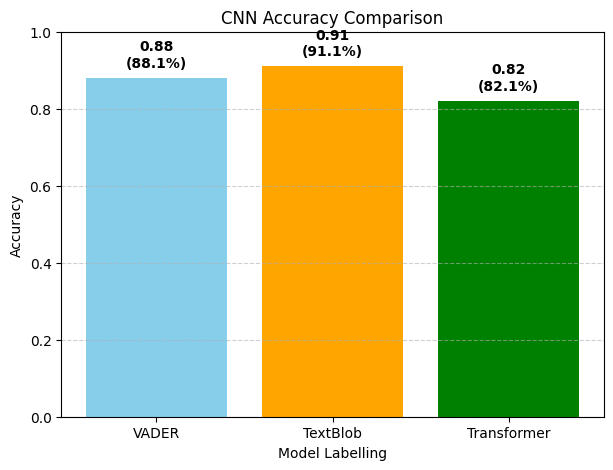

In [ ]:
CNN_Result = {
    'VADER': Vader_CNN[2],
    'TextBlob': TextBlob_CNN[2],
    'Transformer': Transformer_CNN[2],
}

plt.figure(figsize=(7,5))
ax = plt.bar(CNN_Result.keys(), CNN_Result.values(),
             color=['skyblue', 'orange', 'green'])

for i, (model, value) in enumerate(CNN_Result.items()):
    percent = value * 100
    plt.text(i, value + 0.02,
             f"{value:.2f}\n({percent:.1f}%)",  # shows both
             ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')


plt.bar(CNN_Result.keys(), CNN_Result.values(), color=['skyblue','orange','green'])
plt.title("CNN Accuracy Comparison")
plt.xlabel("Model Labelling")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

###### Let’s display the **CNN model results** in a clean table using a DataFrame. This makes it easy to compare the accuracies of **VADER**, **TextBlob**, and **Transformer** sentiment models side by side and identify which one performed best.

In [ ]:
result_CNN = pd.DataFrame(CNN_Result, index=[0])
display(result_CNN)

,VADER,TextBlob,Transformer
0,0.88064,0.9108,0.82064


#### **Using Transformer BERT**

###### We’re fine-tuning a BERT model for sentiment analysis. We take the cleaned text, map each sentiment (Negative, Positive, Neutral) to numbers, split into train/test, tokenize with a pretrained BERT tokenizer, and train a sequence classification model. After training, we measure performance using accuracy, a classification report, and a confusion matrix.

In [ ]:
class _SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]))
        return item

def train_bert_sentiment_model(
    dataframe,
    sentiment_col,
    text_col="text_lemma",
    model_name="bert-base-uncased",
    max_len=128,
    epochs=2,
    batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    random_state=42
):

    label_map = {"Negative": 0, "Positive": 1, "Neutral": 2}
    df = dataframe[[text_col, sentiment_col]].dropna().copy()
    df["label_mapped"] = df[sentiment_col].map(label_map)

    X_train, X_test, y_train, y_test = train_test_split(
        df[text_col].tolist(),
        df["label_mapped"].tolist(),
        test_size=0.2,
        stratify=df["label_mapped"],
        random_state=random_state
    )

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    train_enc = tokenizer(
        X_train, truncation=True, padding=False, max_length=max_len
    )
    test_enc = tokenizer(
        X_test, truncation=True, padding=False, max_length=max_len
    )

    train_ds = _SimpleDataset(train_enc, y_train)
    test_ds = _SimpleDataset(test_enc, y_test)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=3
    )

    collator = DataCollatorWithPadding(tokenizer=tokenizer)
    args = TrainingArguments(
        output_dir="bert_sentiment_outputs",
        eval_strategy="epoch",
        save_strategy="no",
        logging_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=weight_decay,
        report_to=[]
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=tokenizer,
        data_collator=collator,
    )


    trainer.train()

    preds = trainer.predict(test_ds)
    y_pred = np.argmax(preds.predictions, axis=1)

    accuracy = accuracy_score(y_test, y_pred)
    print("\nAccuracy:", round(accuracy, 4))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return model, tokenizer, trainer, accuracy

#### **Transformer with Vader**

In [ ]:
Vader_BERT = train_bert_sentiment_model(Dataframe, 'vader_sentiment')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3756360323.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.334400,0.213805
2,0.167900,0.208705



Accuracy: 0.9425

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      3098
           1       0.96      0.97      0.96      7737
           2       0.94      0.85      0.90      1665

    accuracy                           0.94     12500
   macro avg       0.93      0.92      0.92     12500
weighted avg       0.94      0.94      0.94     12500


Confusion Matrix:
[[2896  172   30]
 [ 216 7467   54]
 [ 114  133 1418]]


#### **Transformer with Transformer**

In [ ]:
Transformer_BERT = train_bert_sentiment_model(Dataframe, 'sentiment')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3756360323.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.362000,0.300782
2,0.199000,0.314311



Accuracy: 0.8976

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      2572
           1       0.87      0.93      0.90      2641
           2       0.94      0.92      0.93      7287

    accuracy                           0.90     12500
   macro avg       0.87      0.89      0.88     12500
weighted avg       0.90      0.90      0.90     12500


Confusion Matrix:
[[2083  187  302]
 [  93 2458   90]
 [ 440  168 6679]]


#### **Transformer with Transformer**

In [ ]:
TextBlob_BERT = train_bert_sentiment_model(Dataframe, 'Blob_Sentiment')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3756360323.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.304100,0.167161
2,0.143000,0.158406



Accuracy: 0.9546

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      2880
           1       0.96      0.97      0.97      7643
           2       0.97      0.95      0.96      1977

    accuracy                           0.95     12500
   macro avg       0.95      0.94      0.95     12500
weighted avg       0.95      0.95      0.95     12500


Confusion Matrix:
[[2618  225   37]
 [ 189 7431   23]
 [  45   49 1883]]


#### **Comparison of the 3 for BERT**

###### Let’s visualize how well our **BERT models** performed across different sentiment labelling methods **VADER**, **TextBlob**, and **Transformer**. This bar chart compares their accuracy to reveal which dataset helped BERT achieve the best performance and most reliable predictions.


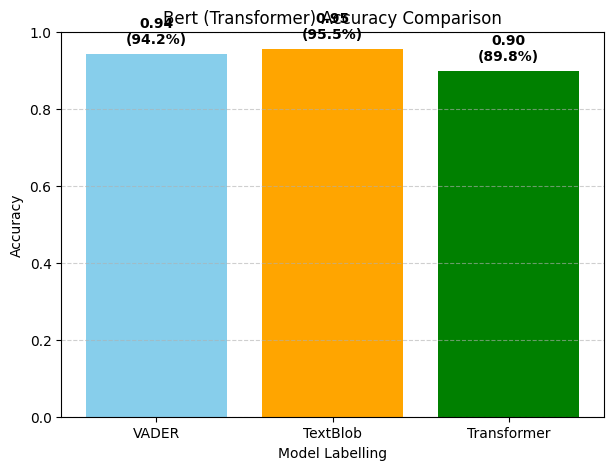

In [ ]:
BERT_Result = {
    'VADER': Vader_BERT[3],
    'TextBlob': TextBlob_BERT[3],
    'Transformer': Transformer_BERT[3]
}
plt.figure(figsize=(7,5))
ax = plt.bar(BERT_Result.keys(), BERT_Result.values(),
             color=['skyblue', 'orange', 'green'])

for i, (model, value) in enumerate(BERT_Result.items()):
    percent = value * 100
    plt.text(i, value + 0.02,
             f"{value:.2f}\n({percent:.1f}%)",  # shows both
             ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')


plt.bar(BERT_Result.keys(), BERT_Result.values(), color=['skyblue','orange','green'])
plt.title("Bert (Transformer) Accuracy Comparison")
plt.xlabel("Model Labelling")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

###### Let’s neatly display our **BERT model results** in a table using a DataFrame. This makes it easy to compare the accuracy of **VADER**, **TextBlob**, and **Transformer** labelling side by side and identify which one produced the best overall performance.

In [ ]:
result_bert = pd.DataFrame(BERT_Result, index=[0])
display(result_bert)

,VADER,TextBlob,Transformer
0,0.94248,0.95456,0.8976


#### **Overall comparison for the 4 Model to know the best model**

###### Here we’re bringing everything together! This dictionary stores the **accuracy results** of all four models — **Naive Bayes**, **SVM**, **CNN**, and **BERT**. for each sentiment labelling method (**VADER**, **TextBlob**, and **Transformer**) so we can easily compare their performances later.

In [ ]:
results = {
    "CNN": {"VADER": Vader_CNN[2], "TextBlob": TextBlob_CNN[2], "Transformer": Transformer_CNN[2]},
    "SVM": {"VADER": Vader_SVM[2], "TextBlob": TextBlob_SVM[2], "Transformer": Transformer_SVM[2]},
    "Naive Bayes": {"VADER": Vader_Naive_Bayes[2], "TextBlob": TextBlob_Naive_Bayes[2], "Transformer": Transformer_Naive_Bayes[2]},
    "BERT": {"VADER": Vader_BERT[3], "TextBlob": TextBlob_BERT[3], "Transformer": Transformer_BERT[3]},
}

###### Let’s organize all our model performances into a clean table! By converting the results dictionary into a DataFrame, we can easily compare how **Naive Bayes**, **SVM**, **CNN**, and **BERT** performed across **VADER**, **TextBlob**, and **Transformer** labels all neatly rounded for clarity.

In [ ]:
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

display(results_df)

,VADER,TextBlob,Transformer
CNN,0.8806,0.9108,0.8206
SVM,0.8742,0.9183,0.8273
Naive Bayes,0.5460,0.5462,0.5407
BERT,0.9425,0.9546,0.8976


###### Let’s visualize the overall performance of all our models! This bar chart compares the accuracies of **Naive Bayes**, **SVM**, **CNN**, and **BERT** across the three sentiment sources **VADER**, **TextBlob**, and **Transformer** to clearly see which combination performed best.

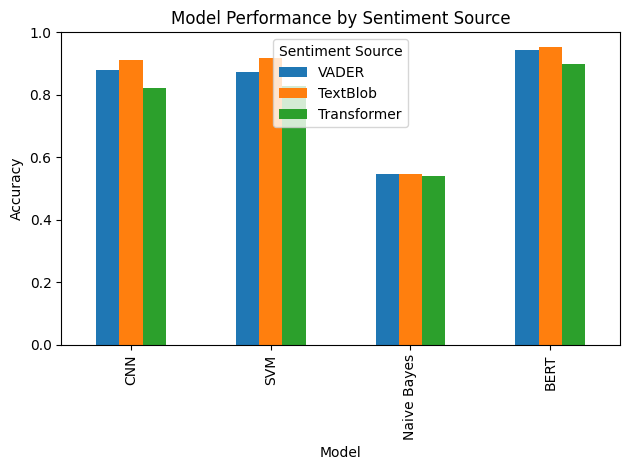

In [ ]:
ax = results_df.plot(kind='bar')
ax.set_title("Model Performance by Sentiment Source")
ax.set_xlabel("Model")
ax.set_ylabel("Accuracy")
ax.set_ylim(0, 1.0)
ax.legend(title="Sentiment Source", loc="best")
plt.tight_layout()
plt.show()

###### Let’s find out which model performed best for each sentiment source! This code checks the **highest accuracy** in each column and prints the **top-performing model** for **VADER**, **TextBlob**, and **Transformer** sentiment labelling.

In [ ]:
best_scores = results_df.idxmax()
print("Best models per sentiment source:")
print(best_scores)

Best models per sentiment source:
VADER          BERT
TextBlob       BERT
Transformer    BERT
dtype: object


###### Let’s create a **heatmap** to visualize model performance more clearly! Each cell shows the accuracy of **Naive Bayes**, **SVM**, **CNN**, and **BERT** across **VADER**, **TextBlob**, and **Transformer** labels, making it easy to spot the strongest results at a glance.

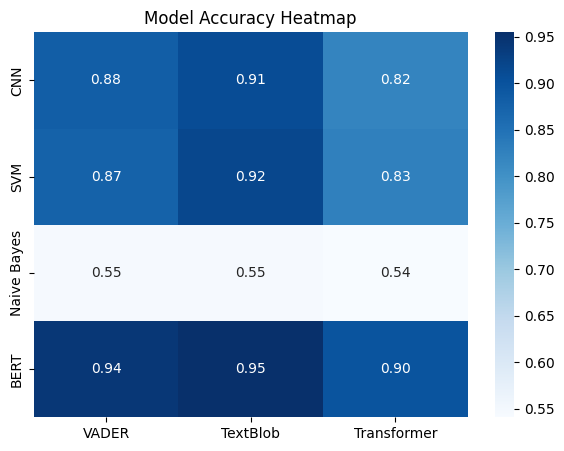

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(results_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("Model Accuracy Heatmap")
plt.show()

##### **Overall Labelling**

###### Let’s calculate the **average accuracy** for each sentiment source across all models. This helps us see whether **VADER**, **TextBlob**, or **Transformer** generally provided better training data for sentiment prediction overall.

In [ ]:
avg_scores = results_df.mean().sort_values(ascending=False)
print(avg_scores)

TextBlob       0.832475
VADER          0.810825
Transformer    0.771550
dtype: float64


###### Let’s visualize the **average accuracy** of each sentiment source across all models! This bar chart clearly shows whether **VADER**, **TextBlob**, or **Transformer** produced better overall results when used to train different sentiment classifiers.

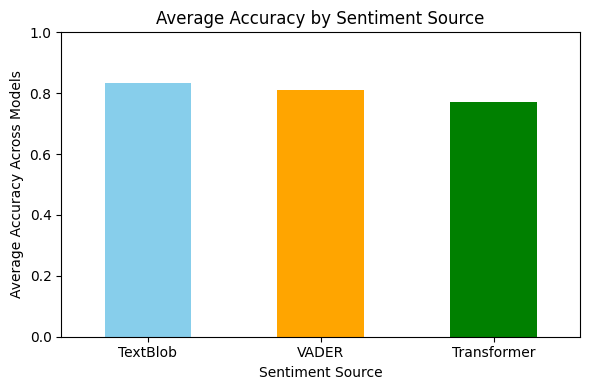

In [ ]:
plt.figure(figsize=(6,4))
avg_scores.plot(kind='bar', color=['skyblue', 'orange', 'green', 'red'])

plt.title('Average Accuracy by Sentiment Source')
plt.xlabel('Sentiment Source')
plt.ylabel('Average Accuracy Across Models')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

###### Let’s identify the **best overall sentiment source** This code finds which dataset **VADER**, **TextBlob**, or **Transformer** achieved the **highest average accuracy** across all models, then prints the top performer along with its exact score.

In [ ]:
best_source = avg_scores.idxmax()
best_score = avg_scores.max()
print(f"Best performing sentiment source: {best_source} ({best_score:.3f})")

Best performing sentiment source: TextBlob (0.832)


#### **For Model**

###### Let’s now check which **model** performed best on average across all sentiment sources. This code calculates the mean accuracy for each model  **Naive Bayes**, **SVM**, **CNN**, and **BERT** helping us see which one delivered the most consistent overall performance.

In [ ]:
avg_model_scores = results_df.mean(axis=1).sort_values(ascending=False)
print(avg_model_scores)

BERT           0.931567
SVM            0.873267
CNN            0.870667
Naive Bayes    0.544300
dtype: float64


###### Let’s visualize how each **model** performed on average across all sentiment sources! This bar chart compares the overall accuracy of **Naive Bayes**, **SVM**, **CNN**, and **BERT**, helping us easily see which model achieved the strongest and most reliable performance.

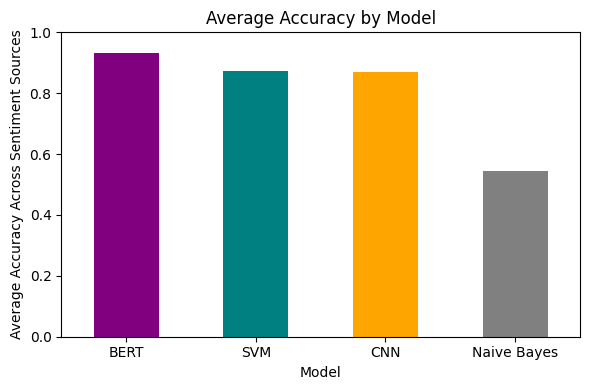

In [ ]:
plt.figure(figsize=(6,4))
avg_model_scores.plot(kind='bar', color=['purple', 'teal', 'orange', 'gray'])

plt.title('Average Accuracy by Model')
plt.xlabel('Model')
plt.ylabel('Average Accuracy Across Sentiment Sources')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

###### Let’s find out which **model** performed the best overall! This code identifies the model whether **Naive Bayes**, **SVM**, **CNN**, or **BERT** with the **highest average accuracy** across all sentiment sources and prints it along with its exact score.

In [ ]:
best_model = avg_model_scores.idxmax()
best_score = avg_model_scores.max()
print(f"Best performing model overall: {best_model} ({best_score:.3f})")

Best performing model overall: BERT (0.932)


###### Let’s save our cleaned and processed dataset! This line exports the entire **DataFrame** to a CSV file named **“Updated_Data.csv”**, excluding the index column, so we can easily reuse it for future analysis or modeling.

In [ ]:
Dataframe.to_csv('Updated_Data.csv', index=False)

### **Topic Modelling**

###### Topic modelling helps uncover hidden themes in text data, like identifying key reasons behind employee concerns in a **job dissatisfaction** dataset.

#### **LDA - Latent Dirichlet Allocation**

In [5]:
data = pd.read_csv('2025_JOB_Dissatisfaction_Sentiment.csv')

In [6]:
display(data)

,id,subreddit,created_utc,text_raw,score,query,label,source,permalink,text_clean,...,Blob_Sentiment,neg,neu,pos,sentiment,all_agree,two_or_more_agree,vader_strength,textblob_strength,transformer_strength
0,1ltd0pl,UKJobs,1.751838e+09,Is there a correlation between unemployment an...,2,job dissatisfaction,Negative,post,https://www.reddit.com/r/UKJobs/comments/1ltd0...,is there a correlation between unemployment an...,...,Positive,0.131145,0.563207,0.020800,Neutral,False,False,0.9201,0.034020,0.563207
1,1l28f88,UKJobs,1.748947e+09,Me and a colleague have been shortlisted for s...,9,job dissatisfaction,Negative,post,https://www.reddit.com/r/UKJobs/comments/1l28f...,me and a colleague have been shortlisted for s...,...,Positive,0.028519,0.104343,0.741284,Positive,False,True,0.2516,0.262500,0.741284
2,1k1kp8i,UKJobs,1.744916e+09,Looking for advice Going to try condense this ...,2,job dissatisfaction,Negative,post,https://www.reddit.com/r/UKJobs/comments/1k1kp...,looking for advice going to try condense this ...,...,Negative,0.101022,0.275912,0.036717,Negative,False,True,0.5367,0.022313,0.275912
3,1of5hu1,UKJobs,1.761331e+09,Is the point of life to just work till your to...,10,hate my job,Negative,post,https://www.reddit.com/r/UKJobs/comments/1of5h...,is the point of life to just work till your to...,...,Positive,0.066344,0.011277,0.404963,Positive,False,True,0.9951,0.051861,0.404963
4,1oesu9x,UKJobs,1.761297e+09,Handing in notice when staff are off? Hello ev...,9,hate my job,Negative,post,https://www.reddit.com/r/UKJobs/comments/1oesu...,handing in notice when staff are off hello eve...,...,Negative,0.044916,0.011419,0.754965,Positive,False,True,0.8664,0.092264,0.754965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62494,mpohzj4,recruitinghell,1.745943e+09,Companies cheat and auto reject anyone without...,4,flexible working,Positive,comment,https://www.reddit.com/r/recruitinghell/commen...,companies cheat and auto reject anyone without...,...,Positive,0.013302,0.672179,0.006329,Neutral,False,False,0.2960,0.250000,0.672179
62495,mpo87od,recruitinghell,1.745940e+09,"Good luck, OP. Sounds just like what happened...",3,flexible working,Positive,comment,https://www.reddit.com/r/recruitinghell/commen...,good luck op sounds just like what happened to...,...,Positive,0.012237,0.213887,0.759692,Positive,True,True,0.8126,0.550000,0.759692
62496,mcf4fyu,recruitinghell,1.739389e+09,The discord for our subreddit can be found her...,1,flexible working,Positive,comment,https://www.reddit.com/r/recruitinghell/commen...,the discord for our subreddit can be found her...,...,Positive,0.024111,0.896784,0.007900,Neutral,False,True,0.6249,0.250000,0.896784
62497,mcimio9,recruitinghell,1.739433e+09,Yeah it's terrible. I'm in London and have bee...,2,flexible working,Positive,comment,https://www.reddit.com/r/recruitinghell/commen...,yeah it's terrible i'm in london and have been...,...,Negative,0.067321,0.018909,0.531621,Positive,False,True,0.2263,0.500000,0.531621


#### **LDA**

In [7]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['text_lemma'].fillna(''))

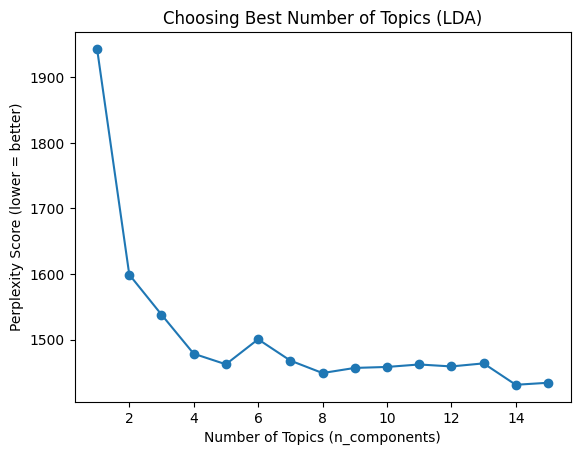

In [8]:
scores = []
topics = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

for n in topics:
    lda = LatentDirichletAllocation(n_components=n, random_state=42)
    lda.fit(X)
    score = lda.perplexity(X)
    scores.append(score)

plt.plot(topics, scores, marker='o')
plt.title("Choosing Best Number of Topics (LDA)")
plt.xlabel("Number of Topics (n_components)")
plt.ylabel("Perplexity Score (lower = better)")
plt.show()

In [9]:
lda = LatentDirichletAllocation(n_components=14, random_state=42)
lda.fit(X)

words = vectorizer.get_feature_names_out()
num_words = 14

for i, topic in enumerate(lda.components_):
    top_words = [words[j] for j in topic.argsort()[-num_words:]]
    print(f"Topic {i+1}: {', '.join(top_words)}")

Topic 1: like, old, family, mum, day, need, work, parent, home, year, time, child, kid, school
Topic 2: shit, sorry, really, know, bad, help, need, mental, say, sound, health, think, like, people
Topic 3: say, good, really, think, know, want, time, life, make, thing, feel, like, work, people
Topic 4: service, require, reading, england, labour, public, benefit, present, member, tax, uk, people, private, government
Topic 5: want, people, toilet, say, look, like, bin, sell, charity, wear, buy, fuck, shop, use
Topic 6: holiday, shift, say, pay, year, use, month, office, home, time, week, hour, work, day
Topic 7: make, new, good, like, salary, want, look, company, time, role, year, pay, work, job
Topic 8: offer, month, notice, need, week, time, tell, company, job, ask, leave, manager, say, work
Topic 9: perform, welcome, break, action, joke, concern, contact, rule, answer, comment, askuk, subreddit, help, question
Topic 10: car, lot, rent, country, year, city, house, people, cost, place, li

In [10]:
doc_topic_dist = lda.transform(X)

In [11]:
data['topic'] = doc_topic_dist.argmax(axis=1)

In [12]:
Topic_suggestion = {
    "Topic 1": "Work-life Balance / Family & Personal Life",
    "Topic 2": "Mental Health / Stress",
    "Topic 3": "Job Satisfaction / Lack of Fulfillment",
    "Topic 4": "Work Conditions / Public vs. Private Sector",
    "Topic 5": "Frustration / Discontent with Work Environment",
    "Topic 6": "Work Hours / Compensation Issues",
    "Topic 7": "Salary and Career Growth",
    "Topic 8": "Resignation / Job Transition",
    "Topic 9": "Workplace Culture / Support Systems",
    "Topic 10": "Cost of Living / Job Location",
    "Topic 11": "Workplace Environment / Disruptions",
    "Topic 12": "Job Fit / Career Advancement",
    "Topic 13": "Social Support / Work-Life Imbalance",
    "Topic 14": "Job Search / Online Communities"
}

print(Topic_suggestion)

{'Topic 1': 'Work-life Balance / Family & Personal Life', 'Topic 2': 'Mental Health / Stress', 'Topic 3': 'Job Satisfaction / Lack of Fulfillment', 'Topic 4': 'Work Conditions / Public vs. Private Sector', 'Topic 5': 'Frustration / Discontent with Work Environment', 'Topic 6': 'Work Hours / Compensation Issues', 'Topic 7': 'Salary and Career Growth', 'Topic 8': 'Resignation / Job Transition', 'Topic 9': 'Workplace Culture / Support Systems', 'Topic 10': 'Cost of Living / Job Location', 'Topic 11': 'Workplace Environment / Disruptions', 'Topic 12': 'Job Fit / Career Advancement', 'Topic 13': 'Social Support / Work-Life Imbalance', 'Topic 14': 'Job Search / Online Communities'}


In [13]:
topic_label_map = {i: Topic_suggestion[f"Topic {i+1}"] for i in range(14)}

data['topic_label'] = data['topic'].map(topic_label_map)

In [14]:
sentiment_summary = (
    data.groupby(['topic_label', 'sentiment'])
      .size()
      .reset_index(name='count')
)

In [15]:
corpus = [vectorizer.inverse_transform(x)[0] for x in X]
dictionary = Dictionary(corpus)

bow_corpus = [dictionary.doc2bow(doc) for doc in corpus]

lda_gensim = LdaModel(bow_corpus, num_topics=7, id2word=dictionary, passes=15, random_state=42)


coherence_model = CoherenceModel(model=lda_gensim, texts=corpus, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print("Coherence Score:", coherence_score)

Coherence Score: 0.8235687024747272


### **Bertopic**

In [16]:
pip install bertopic sentence-transformers umap hdbscan

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 12.8 MB/s eta 0:00:00
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3541 sha256=e45bab381b13689cc123128725d49c81699759a0348c2cc63434053043a0da13
  Stored in directory: /root/.cache/pip/wheels/48/4a/1c/1d511cbb0413a448d8546e958f8e82b98d9bb493038d19ece2
Successfully built umap


In [17]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import pandas as pd


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [18]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [20]:
topic_model = BERTopic(embedding_model=embedding_model, verbose=True)
topics, probs = topic_model.fit_transform(data['text_lemma'].fillna(''))

2025-11-12 15:38:03,492 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1954 [00:00<?, ?it/s]

2025-11-12 15:38:26,155 - BERTopic - Embedding - Completed ✓
2025-11-12 15:38:26,156 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-12 15:38:27,472 - BERTopic - Dimensionality - Completed ✓
2025-11-12 15:38:27,477 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-12 15:38:35,655 - BERTopic - Cluster - Completed ✓
2025-11-12 15:38:35,678 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-12 15:38:37,496 - BERTopic - Representation - Completed ✓


In [21]:
topic_info = topic_model.get_topic_info()
topic_info.head(15)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,55787,-1_work_get_job_go,"[work, get, job, go, would, like, time, people...",[retrain would appreciate advice I sole earner...
1,0,1361,0_post_megathread_ukjob_moderator,"[post, megathread, ukjob, moderator, message, ...",[thank post r ukjob help make well community b...
2,1,1309,1_job_work_role_company,"[job, work, role, company, year, get, experien...",[I take counter offer company year great suppo...
3,2,1130,2_post_thread_megathread_ukjob,"[post, thread, megathread, ukjob, moderator, b...",[thank post r ukjob help make well community b...
4,3,719,3_please_askuk_reple_question,"[please, askuk, reple, question, submission, s...",[please help keep askuk welcome reple submissi...
5,4,211,4_please_askuk_reple_question,"[please, askuk, reple, question, submission, s...",[please help keep askuk welcome reple submissi...
6,5,197,5_please_askuk_reply_question,"[please, askuk, reply, question, submission, s...",[please help keep askuk welcome reply submissi...
7,6,136,6_please_askuk_reple_question,"[please, askuk, reple, question, submission, s...",[please help keep askuk welcome reple submissi...
8,7,128,7____,"[, , , , , , , , , ]","[, , ]"
9,8,97,8_cheese_giphy_gif_downsize,"[cheese, giphy, gif, downsize, ham, crisp, sar...","[gif giphy downsize, gif giphy downsize, yes s..."


In [22]:
for i in range(len(topic_info)):
    print(f"Topic {i}: ", topic_model.get_topic(i))

Topic 0:  [('post', np.float64(0.09031779538961483)), ('megathread', np.float64(0.07625623487936564)), ('ukjob', np.float64(0.07617224361619415)), ('moderator', np.float64(0.06651722544851227)), ('message', np.float64(0.06362222655179056)), ('subreddit', np.float64(0.05907181069817753)), ('duplicate', np.float64(0.050194522622217054)), ('modmail', np.float64(0.05015293562714757)), ('sticky', np.float64(0.05007695936188778)), ('suspicious', np.float64(0.049912377874596764))]
Topic 1:  [('job', np.float64(0.021183815087487654)), ('work', np.float64(0.014046554368184526)), ('role', np.float64(0.013475169558473854)), ('company', np.float64(0.012584852939043954)), ('year', np.float64(0.012172653656596349)), ('get', np.float64(0.011364233087481164)), ('experience', np.float64(0.010937380657983522)), ('pay', np.float64(0.010156066659745357)), ('apply', np.float64(0.009550871920329107)), ('look', np.float64(0.008842736146095442))]
Topic 2:  [('post', np.float64(0.07086473176723625)), ('thread'